# Parkinson's FoG Signal Analysis

## Preliminary Analysis

### File introduction  
In this section we will look at our data for visualization

In [1]:
import os
import pandas as pd

def read_single_csv_file(folder_path, file_index):
    file_list = sorted(os.listdir(folder_path))
    if file_list[file_index].endswith('.csv'):
        file_name = file_list[file_index]
    file_path = os.path.join(folder_path, file_name)
    return pd.read_csv(file_path)
    

In [2]:
folder_path = f'D:\\University\\project_data_files\\tdcsfog'
file_index = 0  # choose different files
imu_signal = read_single_csv_file(folder_path=folder_path, file_index=file_index)
print(imu_signal.shape)
print(imu_signal.head())

del folder_path, file_index, imu_signal

(4682, 7)
   Time      AccV     AccML     AccAP  StartHesitation  Turn  Walking
0     0 -9.533939  0.566322 -1.413525                0     0        0
1     1 -9.536140  0.564137 -1.440621                0     0        0
2     2 -9.529345  0.561765 -1.429332                0     0        0
3     3 -9.531239  0.564227 -1.415490                0     0        0
4     4 -9.540825  0.561854 -1.429471                0     0        0


As we can see there are signals in 3 axes: 'AccV' which is the vertical acceleration, 'AccML' which is the mediolateral acceleration, and lastly 'AccAP' which is the anteroposterior acceleration. The next 3 column are labels which says whether there was a FoG event or not and its type.

We will build a robust system that will be able to classifiy each of the three labels:  
"StartHesitation", "Turn", "Walking"

First we filtered out the files which doesnt have any event at all

In [3]:
folder_path = f'D:\\University\\project_data_files\\tdcsfog\\files_with_fog_events'
file_index = 0
imu_signal = read_single_csv_file(folder_path=folder_path, file_index=file_index)
print(imu_signal.shape)
print(imu_signal.head())

del folder_path, file_index

(4682, 7)
   Time      AccV     AccML     AccAP  StartHesitation  Turn  Walking
0     0 -9.533939  0.566322 -1.413525                0     0        0
1     1 -9.536140  0.564137 -1.440621                0     0        0
2     2 -9.529345  0.561765 -1.429332                0     0        0
3     3 -9.531239  0.564227 -1.415490                0     0        0
4     4 -9.540825  0.561854 -1.429471                0     0        0


### Time Domain  
In this section we will extract our data in each axis in the time domain and plot it while highlighting the FoG events

Now lets move on to analyze a single file in the time and frequency domain while highlighing the FoG events.  
For files from tdcsfog folder, the sampling rate of the files are at 128 Hz.  
For files from defog folder, the sampling rate of the files are at 100 Hz.  
As for now we will only analyze files from tdcsfog folder

First lets look at the signals in each axis in the time domain and highlight where there is a FoG event

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_time_domain_with_fog(time_signal, fog_dict, fs, colors_dict=None, axis=None, axs=None):
    time_s = len(time_signal) / fs
    time_stamps = np.linspace(0, time_s, len(time_signal))
    
    if colors_dict is None:
        colors_dict = {
            'StartHesitation': 'red',
            'Turn': 'blue',
            'Walking': 'green'
        }
    
    if axs is None:
        plt.plot(time_stamps, time_signal, label=axis)
        for label, fog_signal in fog_dict.items():
            plt.fill_between(time_stamps, time_signal.min(), time_signal.max(),
                             where=(fog_signal == 1), color=colors_dict.get(label, 'gray'), alpha=0.3, label=label)
        
        plt.title('Signal in Time Domain with FoG Events')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()
    else:
        axs.plot(time_stamps, time_signal, label=axis)
        for label, fog_signal in fog_dict.items():
            axs.fill_between(time_stamps, time_signal.min(), time_signal.max(),
                             where=(fog_signal == 1), color=colors_dict.get(label, 'gray'), alpha=0.3, label=label)
        
        axs.set_title('Signal in Time Domain with FoG Events')
        axs.set_xlabel('Time (seconds)')
        axs.set_ylabel('Amplitude')
        axs.legend()

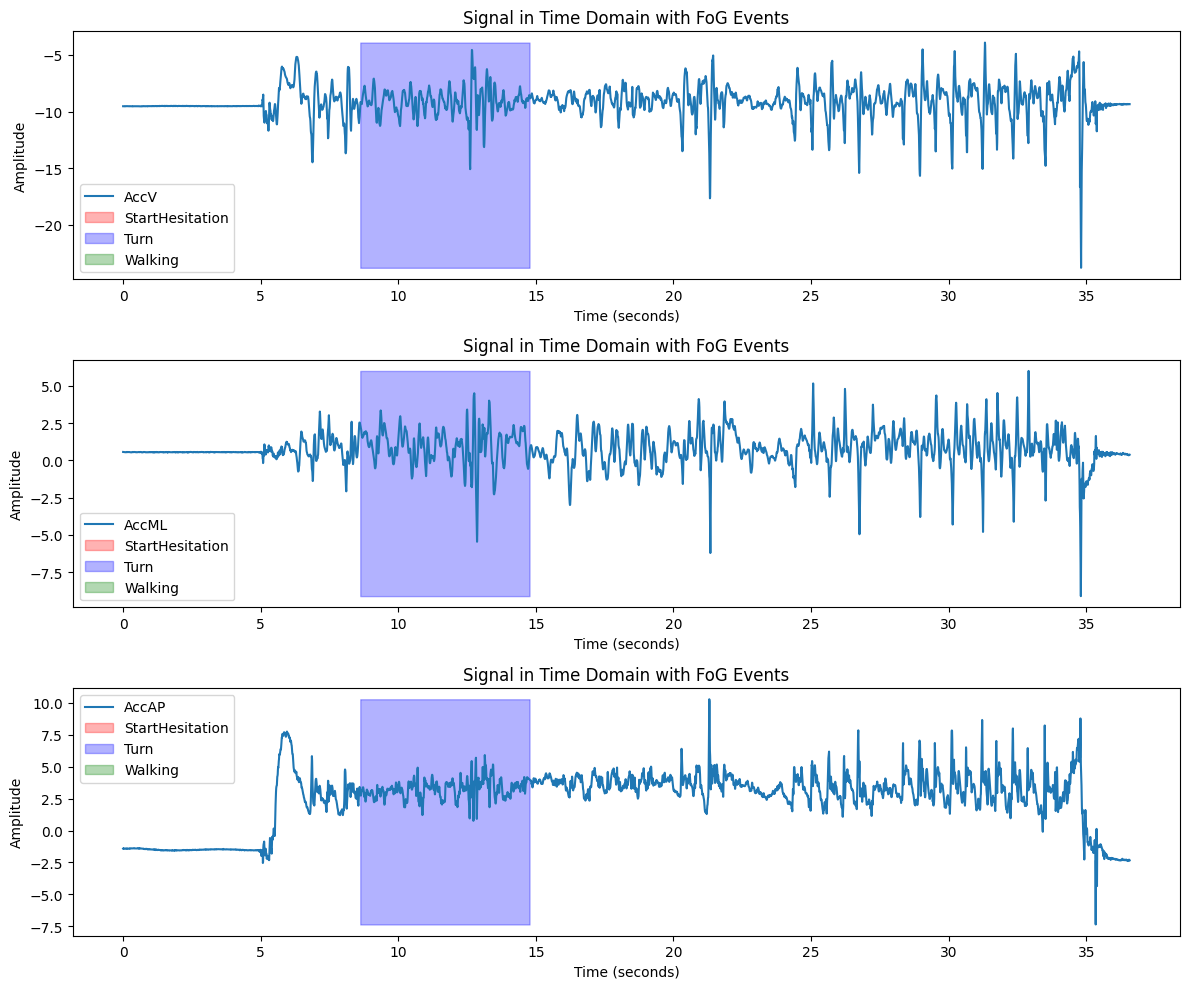

In [5]:
fs = 128
fog_dict = {label: np.array(imu_signal[label]) for label in ['StartHesitation', 'Turn', 'Walking']}
signal_dict = {signal: np.array(imu_signal[signal]) for signal in ['AccV', 'AccML', 'AccAP']}

fig, axs = plt.subplots(3, 1, figsize=(12, 10))
plot_time_domain_with_fog(signal_dict['AccV'], fog_dict=fog_dict, fs=fs, axis='AccV', axs=axs[0])
plot_time_domain_with_fog(signal_dict['AccML'], fog_dict=fog_dict, fs=fs, axis='AccML', axs=axs[1])
plot_time_domain_with_fog(signal_dict['AccAP'], fog_dict=fog_dict, fs=fs, axis='AccAP', axs=axs[2])

plt.tight_layout()
plt.show()

del imu_signal, axs, fig

### Frequency Domain  
In this section we will analyze the frequency domain.  
We will look at an example and finally look at the mean psd over all our files to see the trend and correlation to the literature.

Now lets move to the frequency domain to see which frequencies correlate with eacg specific FoG event.  
We will plot the PSD for each axis for the data where there is FoG event and where there is not separately

In [71]:
from scipy.signal import welch
import matplotlib.pyplot as plt
import numpy as np

def get_psd(time_signal, fog_signal, fs, nperseg, min_freq, max_freq):
    # Compute PSD for FoG events
    fog_indices = np.where(fog_signal == 1)[0]
    signal_fog = time_signal[fog_indices]
    freqs_fog, psd_fog = welch(signal_fog, fs=fs, nperseg=nperseg)
    freq_mask_fog = (freqs_fog >= min_freq) & (freqs_fog <= max_freq)
    masked_psd_fog = psd_fog[freq_mask_fog]
    masked_freqs_fog = freqs_fog[freq_mask_fog]

    # Compute PSD for non-FoG events
    non_fog_indices = np.where(fog_signal == 0)[0]
    signal_no_fog = time_signal[non_fog_indices]
    freqs_no_fog, psd_no_fog = welch(signal_no_fog, fs=fs, nperseg=nperseg)
    freq_mask_no_fog = (freqs_no_fog >= min_freq) & (freqs_no_fog <= max_freq)
    masked_psd_no_fog = psd_no_fog[freq_mask_no_fog]
    masked_freqs_no_fog = freqs_no_fog[freq_mask_no_fog]

    return masked_psd_fog, masked_freqs_fog, masked_psd_no_fog, masked_freqs_no_fog

def plot_frequency_domain(psd, min_freq, max_freq, axis=None, show_non_fog=False, label=None, axs=None, show_title=False):
    ''' 
    psd[0]: PSD of FoG events
    psd[1]: Frequencies for PSD of FoG events
    psd[2]: PSD of non-FoG events
    psd[3]: Frequencies for PSD of non-FoG events
    '''
    if axs is None:
        plt.plot(psd[1], psd[0], label=f'PSD of FOG events from type - {label}', color='red')
        
        if show_non_fog:
            plt.plot(psd[3], psd[2], label='PSD of non FOG events', color='blue')
        
        plt.title(f'{label} - PSD ({min_freq}-{max_freq} Hz)')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power/Frequency')
        plt.xlim(min_freq, max_freq)
        plt.grid(True)
        plt.legend()
        plt.show()
    else:
        axs.plot(psd[1], psd[0], label=f'PSD of {label} events', color='red')
        
        if show_non_fog:
            axs.plot(psd[3], psd[2], label='PSD of non FOG events', color='blue')
        
        axs.set_xlabel('Frequency (Hz)')
        axs.set_ylabel('Power/Frequency')
        axs.set_xlim(min_freq, max_freq)
        axs.grid(True)
        axs.legend()
        if show_title:
            # axs.set_title(f'{label} - PSD ({min_freq}-{max_freq} Hz)', fontsize=16)
            # axs.set_title(f'{axis} - {label}: PSD ({min_freq}-{max_freq} Hz)', fontsize=16)
            axs.set_title(f'{axis} - {label} - PSD ({min_freq}-{max_freq} Hz)', fontsize=16)
    '''
    else:
        axs.plot(psd[1], psd[0], label=f'PSD of {label} Events', color='red')
        
        if show_non_fog:
            axs.plot(psd[3], psd[2], label='No FoG Events', color='blue')
        
        axs.set_xlabel('Frequency (Hz)')
        axs.set_ylabel('Power/Frequency')
        axs.set_xlim(min_freq, max_freq)
        axs.grid(True)
        axs.legend()
        if show_title:
            axs.set_title(f'{label} - PSD ({min_freq}-{max_freq} Hz)', fontsize=16)
    '''
            

# Iterate over fog_dict and plot PSDs
def plot_frequency_domain_events(time_signal, fog_signal, fs, nperseg, min_freq, max_freq, show_non_fog=False, label=None, axs=None):
        psd = get_psd(time_signal=time_signal, fog_signal=fog_signal, fs=fs, nperseg=nperseg, min_freq=min_freq, max_freq=max_freq)
        plot_frequency_domain(psd=psd, min_freq=min_freq, max_freq=max_freq, show_non_fog=show_non_fog, label=label, axs=axs)

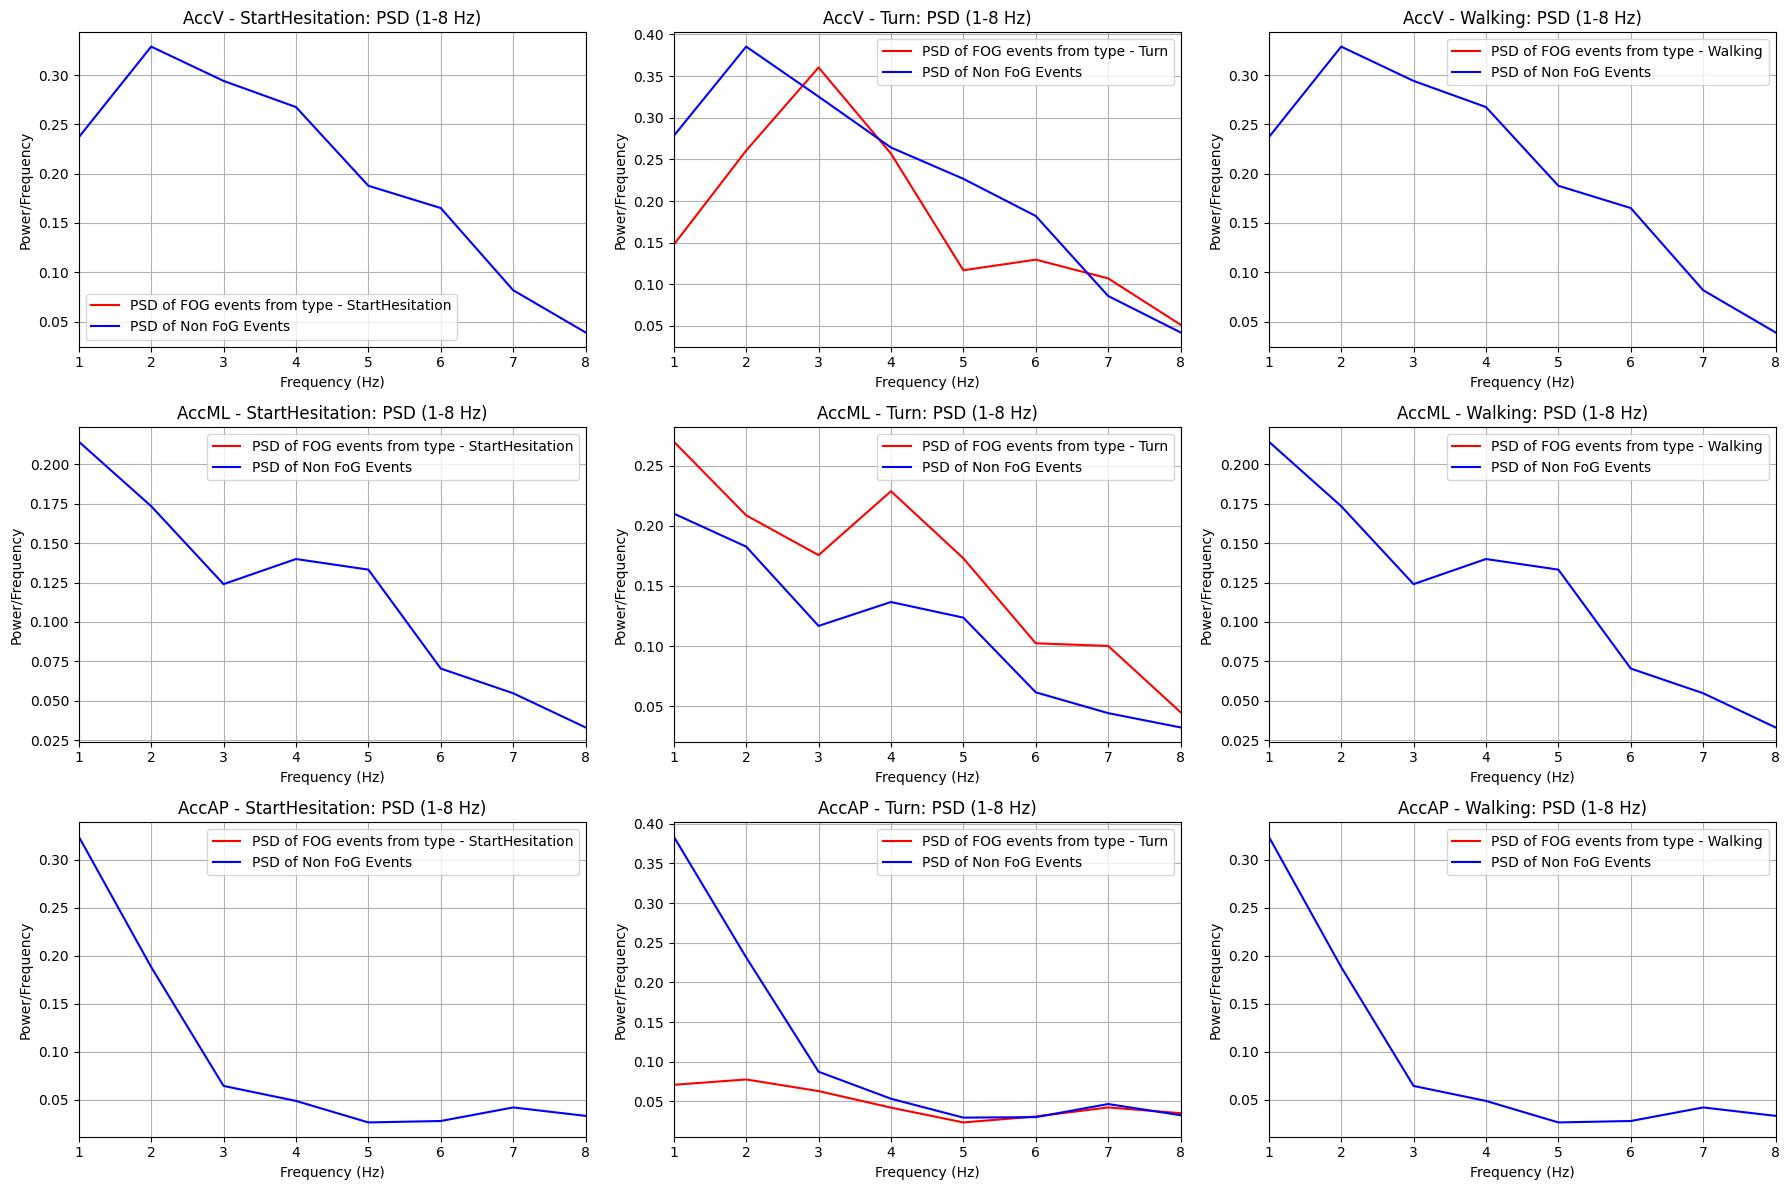

In [52]:
nperseg = fs # 1 Hz resolution, increase for higher frequency resolution
min_freq, max_freq = 1, 8 # filter unnecessary frequencies

fig, axs = plt.subplots(3, 3, figsize=(18, 12))

axes = ['AccV', 'AccML', 'AccAP']
labels = ['StartHesitation', 'Turn', 'Walking']

for i, axis in enumerate(axes):
    for j, label in enumerate(labels):
        plot_frequency_domain_events(time_signal=signal_dict[axis], fog_signal=fog_dict[label], fs=fs, nperseg=nperseg,
                                     min_freq=min_freq, max_freq=max_freq, show_non_fog=True, label=label, axs=axs[i, j])
        axs[i, j].set_title(f'{axis} - {label}: PSD ({min_freq}-{max_freq} Hz)')
        
plt.tight_layout()
plt.show()

del axes, axis, axs, fig, i, j, label, labels

Lets look at some examples for the frequency band that interests us, between 1-15 Hz.  
We use an higher max frequency than 8 Hz because we want to see the correlation decreases as the frequencies increases above 8 Hz.

In [53]:
def plot_frequency_domain_analysis(index_start, num_files, folder_path, fs, nperseg, min_freq, max_freq, show_non_fog):
    axes = ['AccV', 'AccML', 'AccAP']
    labels = ['StartHesitation', 'Turn', 'Walking']
    
    for file_index in range(index_start, index_start + num_files):
        imu_signal = read_single_csv_file(folder_path=folder_path, file_index=file_index)
        fog_dict = {label: np.array(imu_signal[label]) for label in ['StartHesitation', 'Turn', 'Walking']}
        signal_dict = {signal: np.array(imu_signal[signal]) for signal in ['AccV', 'AccML', 'AccAP']}
        
        fig, axs = plt.subplots(3, 3, figsize=(18, 12))
        for i, axis in enumerate(axes):
            for j, label in enumerate(labels):
                plot_frequency_domain_events(time_signal=signal_dict[axis], fog_signal=fog_dict[label], fs=fs, nperseg=nperseg,
                                            min_freq=min_freq, max_freq=max_freq, show_non_fog=show_non_fog, label=label, axs=axs[i, j])
                axs[i, j].set_title(f'File {file_index}: {axis} - {label}: PSD ({min_freq}-{max_freq} Hz)')
        
        plt.tight_layout()
        plt.show()

Choose starting point and how many files to test multiple files frequency domain

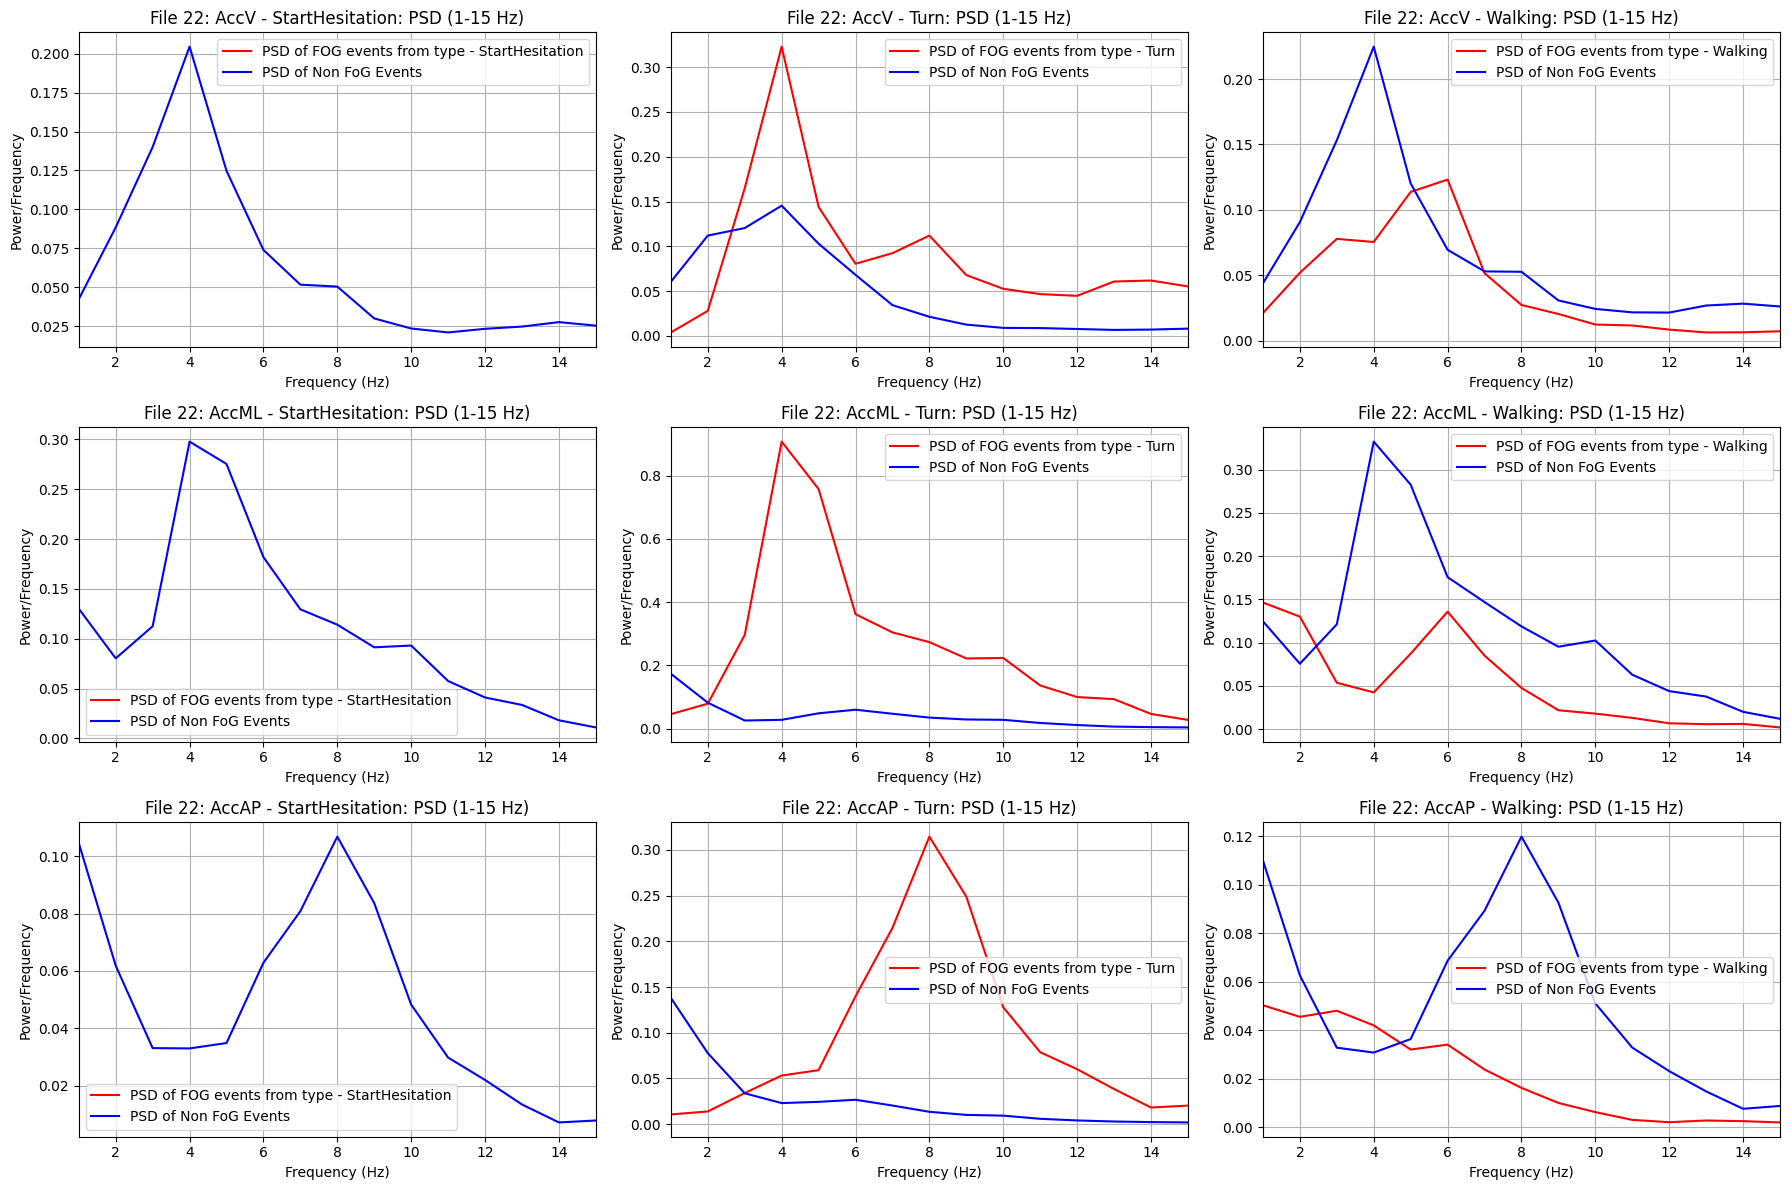

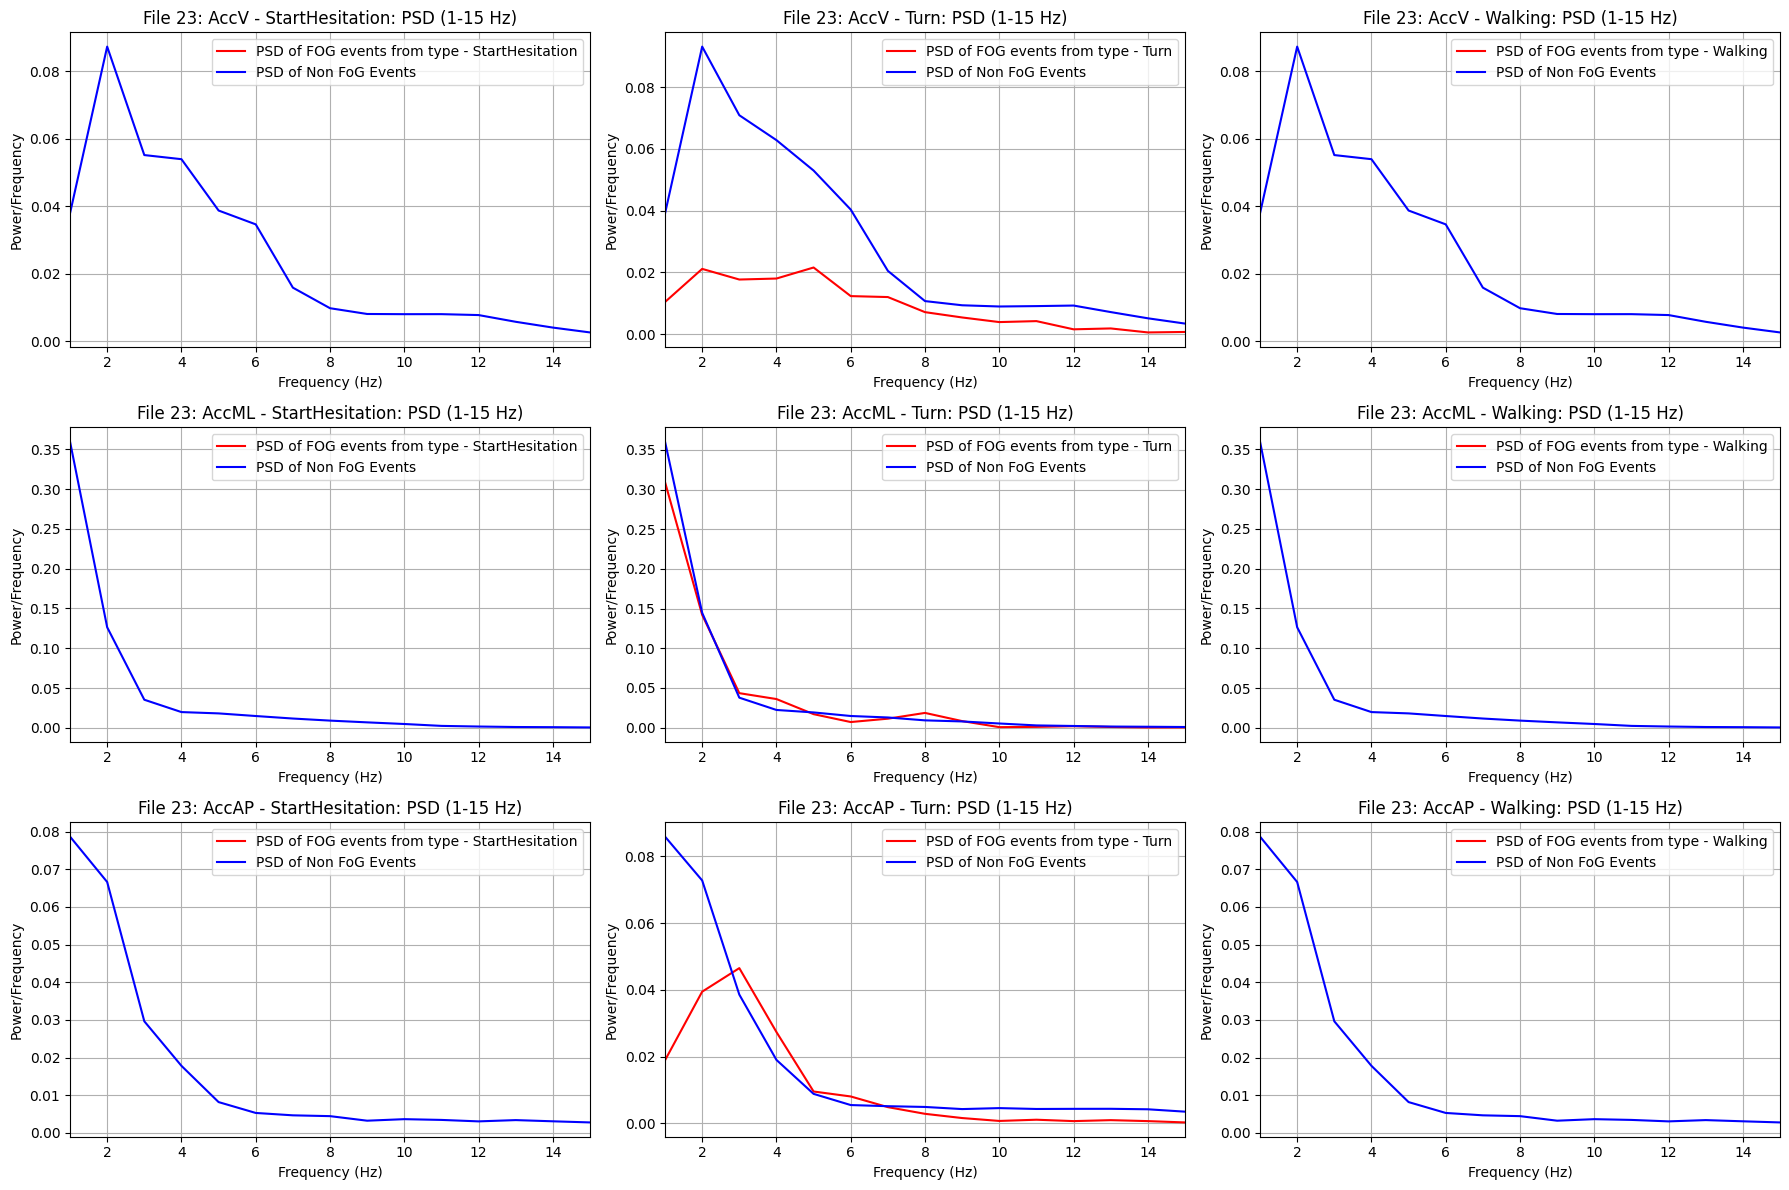

In [54]:
index_start, num_files = 22, 2
folder_path = f'D:\\University\\project_data_files\\tdcsfog\\files_with_fog_events'
fs = 128
nperseg = fs
min_freq, max_freq = 1, 15
plot_frequency_domain_analysis(index_start=index_start, num_files=num_files, folder_path=folder_path,
                               fs=fs, nperseg=nperseg, min_freq=min_freq, max_freq=max_freq, show_non_fog=True)

del index_start, num_files

We can use this code for quick overlook over the psd of different files

Now lets mean over the frequencies for the FoG and Non-FoG events over all files to see if the overall trend correlates with the literature and to find the frequencies that correlates with FoG events.  

In [55]:
def psd_relative_power(psd):
    psd_fog, masked_freqs_fog, psd_no_fog, masked_freqs_no_fog = psd[0], psd[1], psd[2], psd[3]
    total_power_fog = np.sum(psd_fog)
    total_power_no_fog = np.sum(psd_no_fog)
    relative_fog = psd_fog / total_power_fog
    relative_no_fog = psd_no_fog / total_power_no_fog
    return relative_fog, masked_freqs_fog, relative_no_fog, masked_freqs_no_fog


def mean_frequency_domain_analysis(folder_path, fs, nperseg, min_freq, max_freq, labels=['Turn', 'Walking', 'StartHesitation'],
                                   show_non_fog=False, show_relative_power=False):
    num_files = len(os.listdir(folder_path))
    
    psd_lists = {label: { 'AccV': [], 'AccML': [], 'AccAP': [] } for label in labels }
    valid_num_files = {label: 0 for label in labels}
    
    for file_index in range(num_files):
        imu_signal = read_single_csv_file(folder_path=folder_path, file_index=file_index)
        accv = np.array(imu_signal['AccV'])
        accml = np.array(imu_signal['AccML'])
        accap = np.array(imu_signal['AccAP'])

        for label in labels:
            fog_signal = np.array(imu_signal[label])
            if np.sum(fog_signal) < fs:  # Skip files without significant events for the current label
                continue
            valid_num_files[label] += 1
            psd_accv = get_psd(accv, fog_signal, fs, nperseg, min_freq, max_freq)
            psd_accml = get_psd(accml, fog_signal, fs, nperseg, min_freq, max_freq)
            psd_accap = get_psd(accap, fog_signal, fs, nperseg, min_freq, max_freq)
            
            psd_lists[label]['AccV'].append(psd_accv)
            psd_lists[label]['AccML'].append(psd_accml)
            psd_lists[label]['AccAP'].append(psd_accap)

    for label in labels:
        if valid_num_files[label] == 0:
            print(f"No valid files found for label: {label}")
            continue

        # Calculate the mean PSD for each signal type
        mean_accv_psd = np.mean(psd_lists[label]['AccV'], axis=0)
        mean_accml_psd = np.mean(psd_lists[label]['AccML'], axis=0)
        mean_accap_psd = np.mean(psd_lists[label]['AccAP'], axis=0)

        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        plot_frequency_domain(mean_accv_psd, min_freq=min_freq, axis='AccV', max_freq=max_freq,
                              show_non_fog=show_non_fog, label=label, axs=axs[0], show_title=True)
        plot_frequency_domain(mean_accml_psd, min_freq=min_freq, axis='AccML', max_freq=max_freq,
                              show_non_fog=show_non_fog, label=label, axs=axs[1], show_title=True)
        plot_frequency_domain(mean_accap_psd, min_freq=min_freq, axis='AccAP', max_freq=max_freq,
                              show_non_fog=show_non_fog, label=label, axs=axs[2], show_title=True)
        '''
        plot_frequency_domain(mean_accv_psd, min_freq=min_freq, max_freq=max_freq,
                              show_non_fog=show_non_fog, label=f'Mean AccV - {label}', axs=axs[0], show_title=True)
        plot_frequency_domain(mean_accml_psd, min_freq=min_freq, max_freq=max_freq,
                              show_non_fog=show_non_fog, label=f'Mean AccML - {label}', axs=axs[1], show_title=True)
        plot_frequency_domain(mean_accap_psd, min_freq=min_freq, max_freq=max_freq,
                              show_non_fog=show_non_fog, label=f'Mean AccAP - {label}', axs=axs[2], show_title=True)
        '''
        plt.tight_layout()
        plt.show()

        if show_relative_power:
            relative_accv_psd = psd_relative_power(mean_accv_psd)
            relative_accml_psd = psd_relative_power(mean_accml_psd)
            relative_accap_psd = psd_relative_power(mean_accap_psd)
            fig, axs = plt.subplots(1, 3, figsize=(18, 6))
            plot_frequency_domain(relative_accv_psd, min_freq=min_freq, max_freq=max_freq,
                                  show_non_fog=show_non_fog, label=f'Relative AccV - {label}', axs=axs[0], show_title=True)
            plot_frequency_domain(relative_accml_psd, min_freq=min_freq, max_freq=max_freq,
                                  show_non_fog=show_non_fog, label=f'Relative AccML - {label}', axs=axs[1], show_title=True)
            plot_frequency_domain(relative_accap_psd, min_freq=min_freq, max_freq=max_freq,
                                  show_non_fog=show_non_fog, label=f'Relative AccAP - {label}', axs=axs[2], show_title=True)
            plt.tight_layout()
            plt.show()


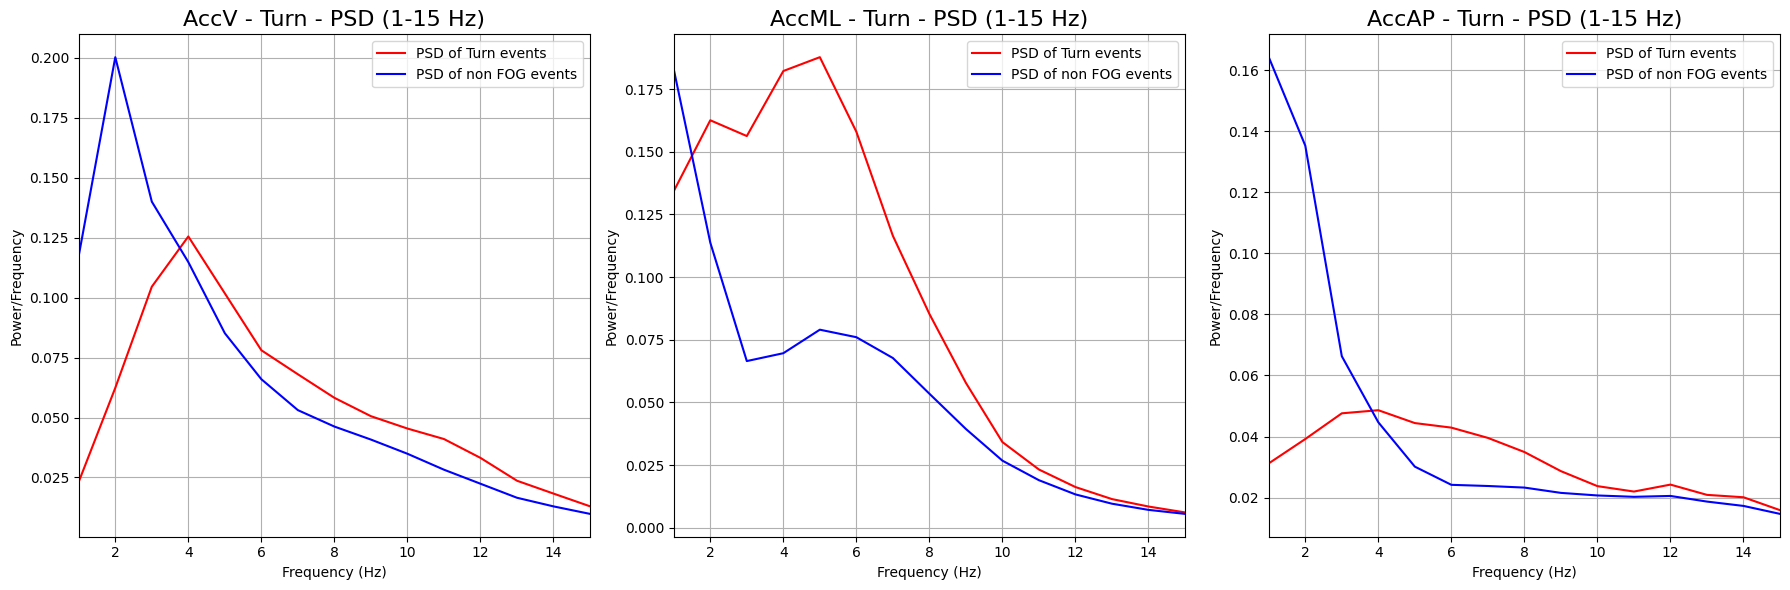

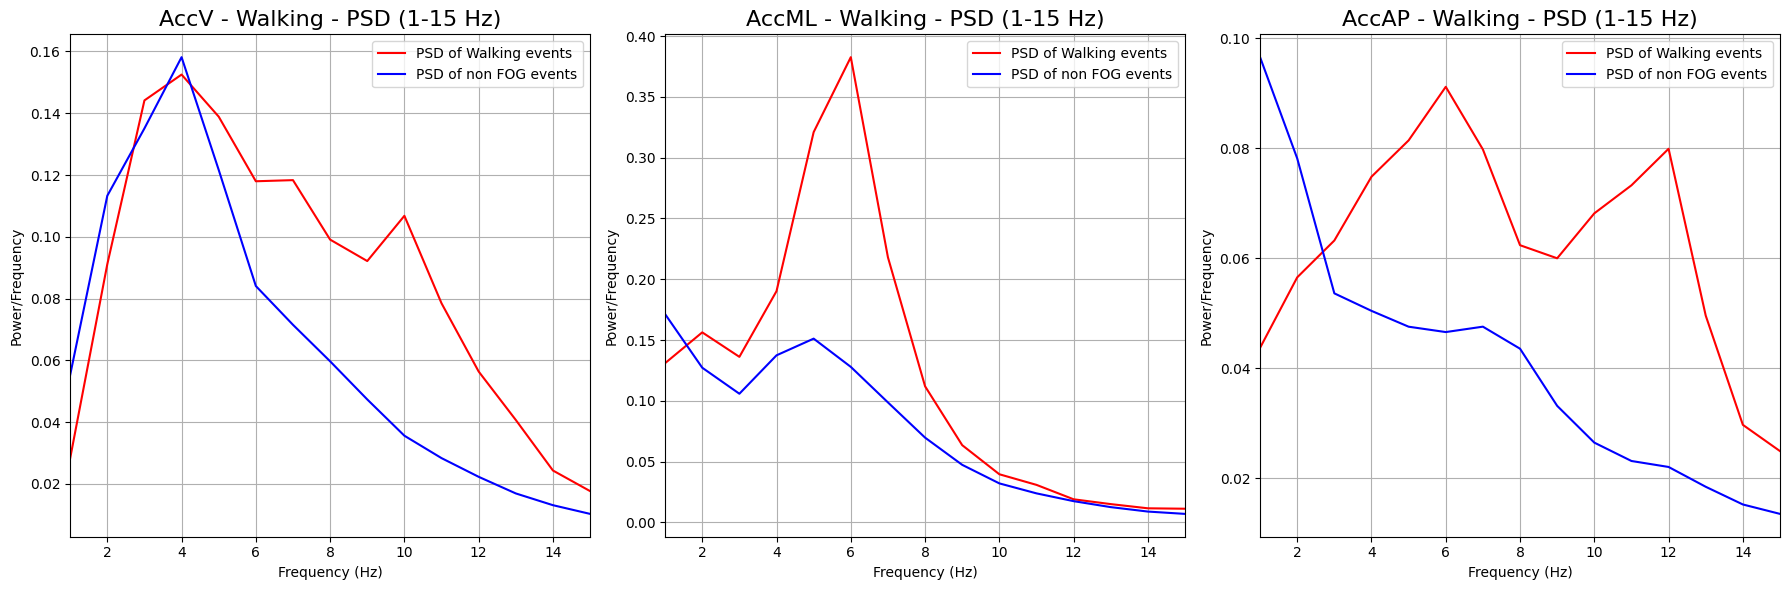

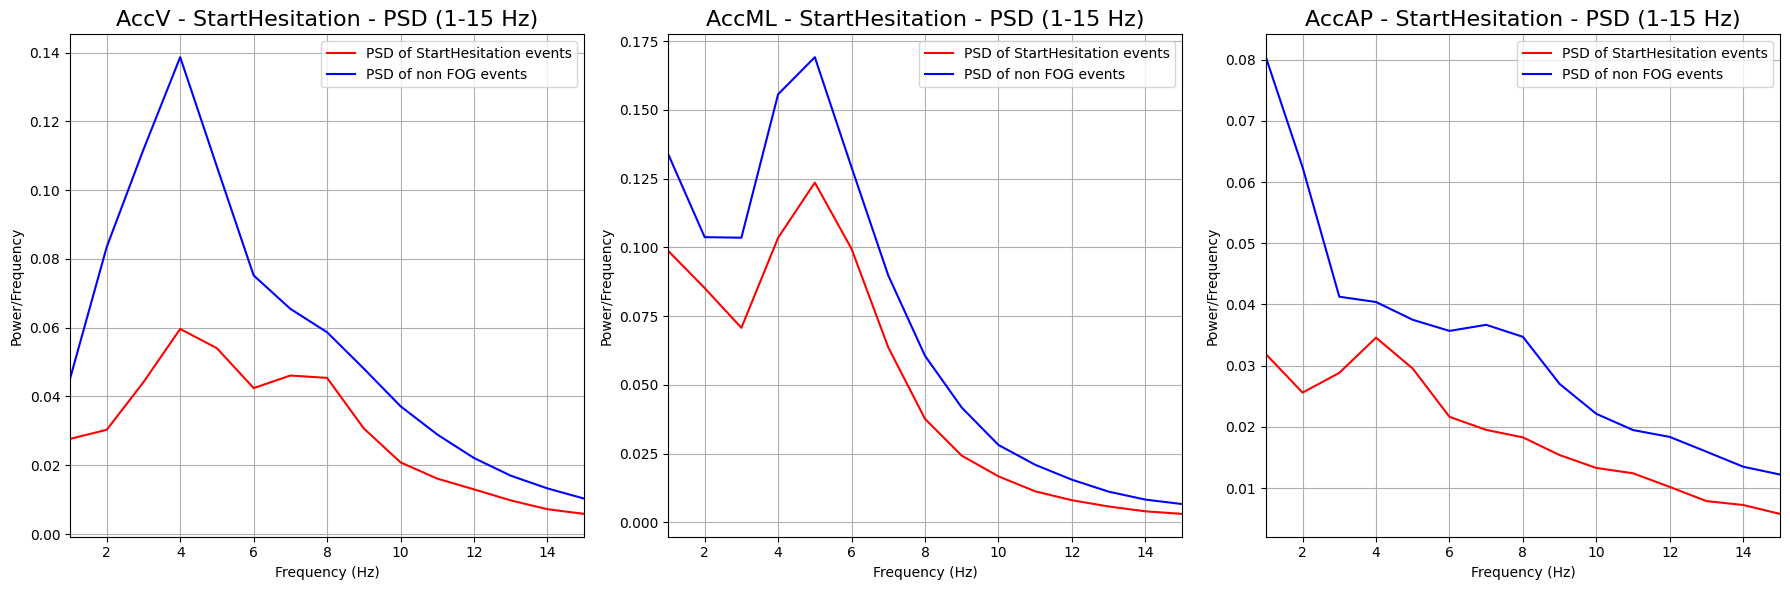

In [72]:
folder_path = f'D:\\University\\project_data_files\\tdcsfog\\files_with_fog_events'
fs = 128
nperseg = fs
min_freq, max_freq = 1, 15

mean_frequency_domain_analysis(folder_path=folder_path, fs=fs, nperseg=nperseg,
                               min_freq=min_freq, max_freq=max_freq, show_non_fog=True, show_relative_power=False)


Now lets focus on the frequency band from 1-8 Hz

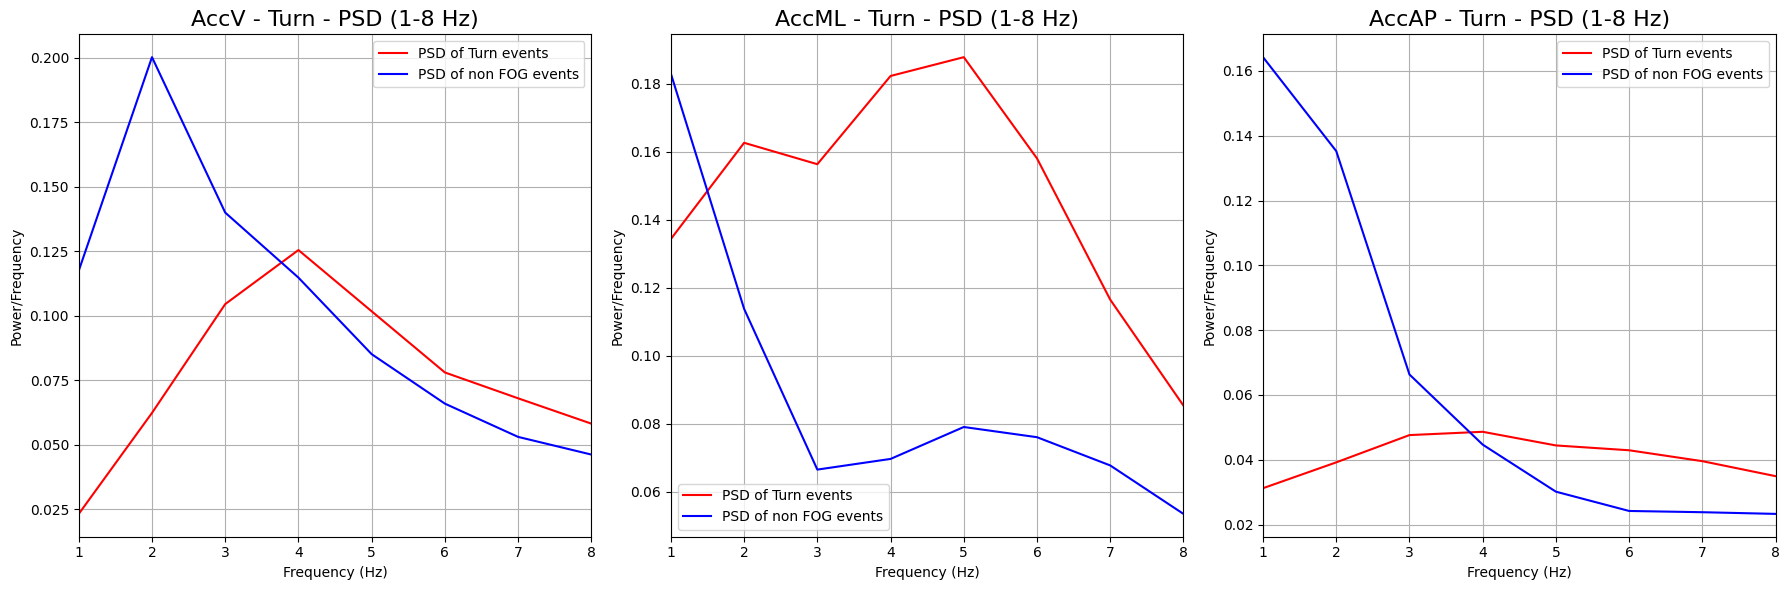

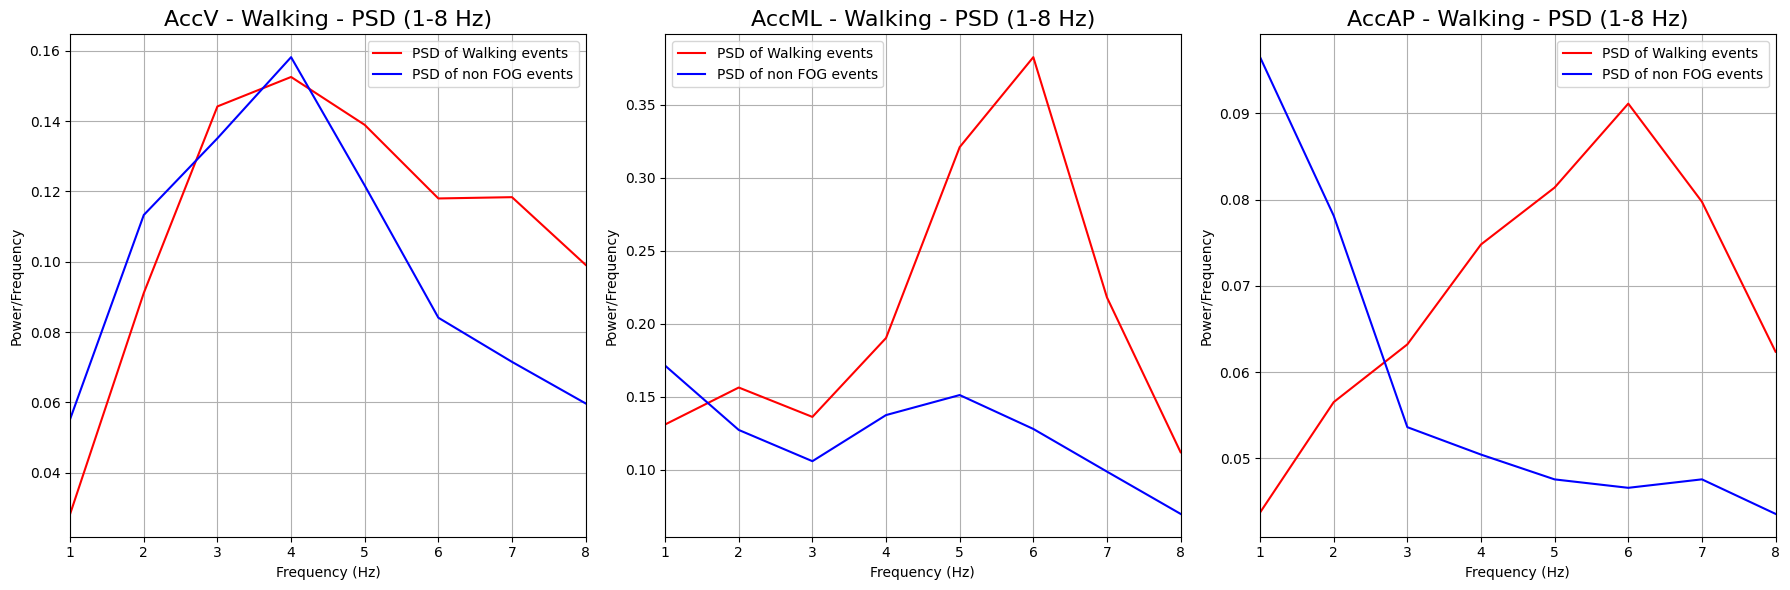

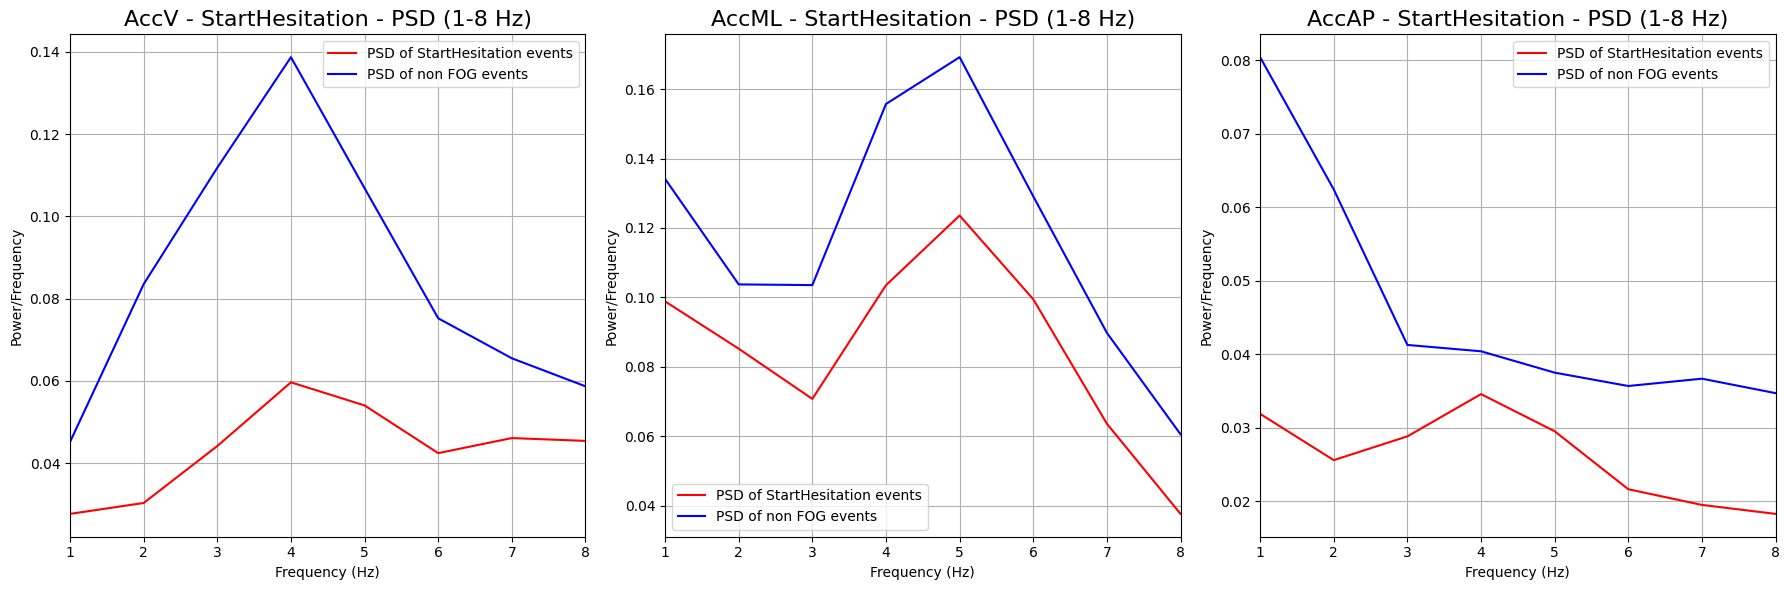

In [73]:
folder_path = f'D:\\University\\project_data_files\\tdcsfog\\files_with_fog_events'
fs = 128
nperseg = fs
min_freq, max_freq = 1, 8

mean_frequency_domain_analysis(folder_path=folder_path, fs=fs, nperseg=nperseg, min_freq=min_freq, max_freq=max_freq, 
                               labels=['Turn', 'Walking', 'StartHesitation'], show_non_fog=True, show_relative_power=False)

del folder_path, min_freq, max_freq, nperseg

## Resonators Analysis

### Signal Proccessing and Resonators creation  
In this section we will adjust our time signal and FoG event type signals to the resonators.  
Then we will create the resonators in the bands that we want and their corresponding spikes event per each resonator is each axis.

The resonators are derived from a signal with frequency of 15360 Hz, meaning we need to resample our 128 Hz to 15360 Hz.  
For aliasing reasons we will pass the signal in band-pass filter with lowcut of 1 Hz and highcut of 8 Hz.  
Lets try to run with 1536*5 Hz, the resonators are resonator freq is accurate and will be much faster than 15360 Hz.

In [145]:
from scipy.signal import butter, filtfilt, resample
from tqdm import tqdm
from sctn.resonator import resonator

def band_pass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def resample_signal(f_new, f_source, data):
    n_samples_orig = data.shape[0]
    n_samples_new = int(n_samples_orig * f_new / f_source)
    return resample(data, n_samples_new)

def resample_fog_signal(f_new, f_source, fog_signal):
    resampled_fog_signal = resample_signal(f_new, f_source, fog_signal)
    resampled_fog_signal = np.round(resampled_fog_signal).astype(int)
    return resampled_fog_signal

def process_signal(signal, f_source, f_new, lowcut, highcut):
    filtered_signal = band_pass_filter(signal, lowcut, highcut, fs=f_source)
    return resample_signal(f_new, f_source, filtered_signal)

def create_resonators(signal_dict, fog_events_dict, resonators_freqs, f_source=128, f_new=15360, lowcut=1, highcut=8, clk_freq=15360):
    resonators_output_dict = {}
    resampled_labeled_data = {}
    resampled_original_data = {}
    
    for label, fog_signal in fog_events_dict.items():
        resampled_labeled_data[label] = resample_fog_signal(f_new, f_source, fog_signal)
    
    with tqdm(total=len(signal_dict) * len(resonators_freqs)) as pbar:
        for signal_name, signal in signal_dict.items():
            # Process signal: Filter and resample
            processed_signal = process_signal(signal, f_source, f_new, lowcut, highcut)
            resampled_original_data[signal_name] = processed_signal
            
            resonators_output_dict[signal_name] = {}
            
            for f0 in resonators_freqs:
                # Initialize resonator
                my_resonator = resonator(freq0=f0, clk_freq=clk_freq)
                my_resonator.log_out_spikes(-1)
                resonator_output_neuron = my_resonator.layers_neurons[-1].neurons[-1]
                
                # Feed resampled signal into the resonator
                my_resonator.input_full_data(processed_signal)
                # Store the resonator output
                resonators_output_dict[signal_name][f0] = resonator_output_neuron.out_spikes()
                pbar.update(1)

    return resonators_output_dict, resampled_labeled_data, resampled_original_data

def create_spikes_events(resonators_dict, clk_freq, time_s, plot_event=False):
    resonators_spikes_dict = {}
    for axis, resonators in resonators_dict.items():
        resonators_spikes_dict[axis] = {}
        for frequency, events in resonators.items():
            spikes_event = np.zeros(int(clk_freq*time_s))
            spikes_event[events] = 1
            resonators_spikes_dict[axis][frequency] = spikes_event
            if plot_event==True:
                plt.figure()
                spike_domain_event = np.convolve(spikes_event, np.ones(1000, dtype=int), 'valid')
                plt.plot(np.linspace(0, time_s, len(spike_domain_event)), spike_domain_event)
                plt.xlabel('Seconds')
                plt.ylabel('Amplitude')
                plt.title(f'Spikes event signal:axis-{axis},resonator_freq-{frequency}')
                plt.show()
    return resonators_spikes_dict

We will focus on the frequencies between 1-8 Hz and divide it to 3 bands: 1-2 Hz, 3-5 Hz, 6-8 Hz.  
Here we can change the clk_freq, use multipliers of 1536, low clk_freq will result in faster resonators creation while the accuracy will be lower and vice versa.  
For now the optimal clk_freq is 7680 Hz.

In [146]:
# clk_freq = 1536 # Fastest
clk_freq = 15360 # Most accurate

bands = {
    '1 Hz':(0.5,1.5),
    '2 Hz':(1.5,2.5),
    '3 Hz':(2.5,3.5),
    '4 Hz':(3.5,4.5),
    '5 Hz':(4.5,5.5),
    '6 Hz':(5.5,6.5),
    '7 Hz':(6.5,7.5),
    '8 Hz':(7.5,8.5),
}

low_freq = [1.17,2]
medium_freq = [3,4,5]
high_freq = [6,6.94,8]

# low_freq = [1.17, 1.9]
# medium_freq = [3.05, 4.02, 4.77]
# high_freq = [5.87, 6.36, 6.94, 7.63]

# low_freq = [1.17, 1.35, 1.59, 1.9]
# medium_freq = [3.05, 3.47, 4.02, 4.36, 4.77]
# high_freq = [5.87, 6.36, 6.94, 7.63]

resonators_freqs = low_freq + medium_freq + high_freq

print(bands)
print(resonators_freqs)

del low_freq, medium_freq, high_freq

{'1 Hz': (0.5, 1.5), '2 Hz': (1.5, 2.5), '3 Hz': (2.5, 3.5), '4 Hz': (3.5, 4.5), '5 Hz': (4.5, 5.5), '6 Hz': (5.5, 6.5), '7 Hz': (6.5, 7.5), '8 Hz': (7.5, 8.5)}
[1.17, 2, 3, 4, 5, 6, 6.94, 8]


Lets read a file

In [147]:
folder_path = f'D:\\University\\project_data_files\\tdcsfog\\files_with_fog_events'
file_index = 3
imu_signal = read_single_csv_file(folder_path=folder_path, file_index=file_index)

fog_dict = {label: np.array(imu_signal[label]) for label in ['StartHesitation', 'Turn', 'Walking']}
signal_dict = {signal: np.array(imu_signal[signal]) for signal in ['AccV', 'AccML', 'AccAP']}
time_s = len(signal_dict['AccV']) / fs

del folder_path, file_index, imu_signal

Lets create the resonators and the spikes events.  
*** If in the future there will be a problem of the size of the spikes events, change the function so that it will not take time_s, but the size of the fog_dict_r or signal_dict_r

In [148]:
resonators_dict, fog_dict_r, signal_dict_r = create_resonators(signal_dict=signal_dict,
                                                               fog_events_dict=fog_dict,
                                                               resonators_freqs=resonators_freqs,
                                                               f_source=128,
                                                               f_new=clk_freq,
                                                               lowcut=1,
                                                               highcut=8,
                                                               clk_freq=clk_freq)

resonators_spikes_dict = create_spikes_events(resonators_dict=resonators_dict,
                                              clk_freq=clk_freq,
                                              time_s=time_s,
                                              plot_event=False)

100%|██████████| 24/24 [35:33<00:00, 88.90s/it] 


### Spectrogram and Spikegram  
In this section we will create the Spectrogram based of FFT in the required band and create a Spikegram for this band using our resonators.  
Then we will show that the Spectrogram and Spikegram are correlated.

Now lets create the resonators based spikegram and adapt it to our bands.

In [149]:
def spikegram_from_spikes_event(spikes_event, clk_freq, window_ms=None, time_s=None):
    ''' Create a Spectrogram from spikes event for a specified bins in miliseconds, default is 1 sec '''
    samples = spikes_event.size
    
    if time_s == None:
        time_s = samples // clk_freq # duration of signal in second rounded down
        
    if window_ms == None:
        window_ms = 1000   # Window size of 1 second
        
    num_bins = (time_s * 1000) // window_ms
    window_size = (clk_freq * window_ms) // 1000
    spikes_spectrogram = np.zeros(num_bins)
    for bin in range(num_bins):
        spikes_spectrogram[bin] = np.sum(spikes_event[bin*window_size: (1+bin)*window_size+1])
    
    return spikes_spectrogram

def create_spikegram(resonators_spikes_dict, clk_freq, window_ms=None, time_s=None):
    spikegram = {}
    time_bins = int(time_s) * 1000 // window_ms
    for axis, resonators_spikes in resonators_spikes_dict.items():
        spikegram[axis] = np.zeros((len(resonators_spikes), time_bins))   # for each axis: #resonators X #bins
        for n, spikes_event in enumerate(resonators_spikes.values()):
            spikegram[axis][n] = spikegram_from_spikes_event(spikes_event, clk_freq=clk_freq, window_ms=window_ms, time_s=int(time_s))
            spikegram[axis][n] -= np.mean(spikegram[axis][n])
            spikegram[axis][n][spikegram[axis][n] < 0] = 0
    return spikegram

In [150]:
spikegram_time_window_ms = 10 # Choose how wide each bin in the time axis will be of the spikegram
# windows size of 1000 ms means that each time bin will be 1 sec, adjust for accuracy

spikegram = create_spikegram(resonators_spikes_dict=resonators_spikes_dict,
                             clk_freq=clk_freq,
                             window_ms=spikegram_time_window_ms,
                             time_s=time_s)

We now have the spikegram for our resonators in each axis.

In [151]:
def plot_spikegram(spikegram, title, fig=None, axs=None, y_label=None, is_bands=False):
    spikegram_normalized = (spikegram - np.min(spikegram)) / (np.max(spikegram) - np.min(spikegram))

    # For testing single spikegram
    if fig==None:
        fig, axs = plt.subplots(1, 1, figsize=(14, 6))
    
    # Create the plot
    im = axs.imshow(spikegram_normalized, aspect='auto', cmap='jet', origin='lower')
    if is_bands == False:
        axs.set_yticks(ticks=np.arange(spikegram_normalized.shape[0]), labels=[f'{f:.2f} Hz' for f in y_label])
    else:
        axs.set_yticks(ticks=np.arange(spikegram_normalized.shape[0]), labels=[f'{name}' for name in y_label.keys()])
    cbar = fig.colorbar(im, ax=axs)
    cbar.ax.tick_params(labelsize=0)
    axs.set_xlabel('Seconds')
    if is_bands == False:
        axs.set_ylabel('Resonators')
    axs.set_title(f'{title} - Resonators based Spikegram')

def plot_full_spikegram(spikegram, resonators_spikes_dict=None, bands=None, fig=None, axs=None, col=None):
    if col==None:
        fig, axs = plt.subplots(3, 1, figsize=(14, 12))
        if bands == None:
            for ax, (axis, resonators_spikes) in enumerate(resonators_spikes_dict.items()):
                plot_spikegram(spikegram=spikegram[axis], title=axis, y_label=resonators_spikes.keys(), is_bands=False, fig=fig, axs=axs[ax])
        if bands != None:
            for ax, axis in enumerate(resonators_spikes_dict.keys()):
                plot_spikegram(spikegram=spikegram[axis], title=axis, y_label=bands, is_bands=True, fig=fig, axs=axs[ax])
        fig.tight_layout()
        plt.show()
        
    else:
        if bands == None:
            for ax, (axis, resonators_spikes) in enumerate(resonators_spikes_dict.items()):
                plot_spikegram(spikegram=spikegram[axis], title=axis, y_label=resonators_spikes.keys(), is_bands=False, fig=fig, axs=axs[ax][col])
        if bands != None:
            for ax, axis in enumerate(resonators_spikes_dict.keys()):
                plot_spikegram(spikegram=spikegram[axis], title=axis, y_label=bands, is_bands=True, fig=fig, axs=axs[ax][col])

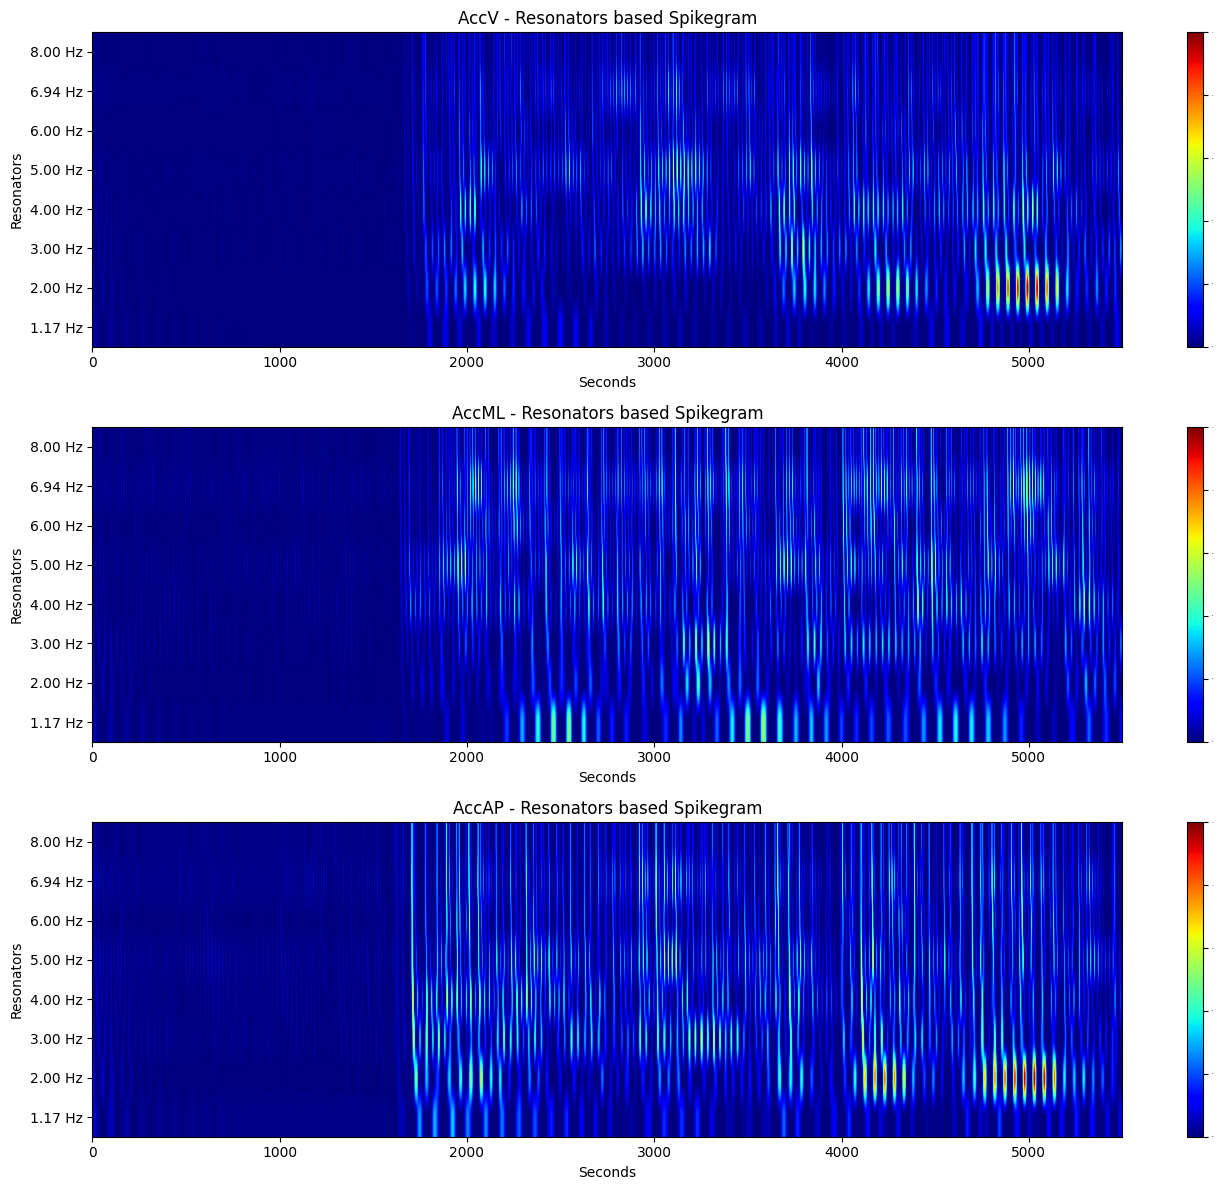

In [152]:
plot_full_spikegram(spikegram=spikegram, resonators_spikes_dict=resonators_spikes_dict)

Lets plot them in the respective bands that we want to analyze

In [153]:
def spikegram_to_bands(spikegram, freqs, bands):
    spikegram_shape = spikegram.shape
    freqs = np.array(freqs)
    spikegram_bands = np.zeros((len(bands), spikegram_shape[1]))
    spikegram_bands[0] = np.sum(spikegram[(freqs >= 0.5) & (freqs < 1.5)], axis=0)
    spikegram_bands[1] = np.sum(spikegram[(freqs >= 1.5) & (freqs < 2.5)], axis=0)
    spikegram_bands[2] = np.sum(spikegram[(freqs >= 2.5) & (freqs < 3.5)], axis=0)
    spikegram_bands[3] = np.sum(spikegram[(freqs >= 3.5) & (freqs < 4.5)], axis=0)
    spikegram_bands[4] = np.sum(spikegram[(freqs >= 4.5) & (freqs < 5.5)], axis=0)
    spikegram_bands[5] = np.sum(spikegram[(freqs >= 5.5) & (freqs < 6.5)], axis=0)
    spikegram_bands[6] = np.sum(spikegram[(freqs >= 6.5) & (freqs < 7.5)], axis=0)
    spikegram_bands[7] = np.sum(spikegram[(freqs >= 7.5) & (freqs < 8.5)], axis=0)
    
    spikegram_bands[0] /= sum(freqs[(freqs >= 0.5) & (freqs < 1.5)])
    spikegram_bands[1] /= sum(freqs[(freqs >= 1.5) & (freqs < 2.5)])
    spikegram_bands[2] /= sum(freqs[(freqs >= 2.5) & (freqs < 3.5)])
    spikegram_bands[3] /= sum(freqs[(freqs >= 3.5) & (freqs < 4.5)])
    spikegram_bands[4] /= sum(freqs[(freqs >= 4.5) & (freqs < 5.5)])
    spikegram_bands[5] /= sum(freqs[(freqs >= 5.5) & (freqs < 6.5)])
    spikegram_bands[6] /= sum(freqs[(freqs >= 6.5) & (freqs < 7.5)])
    spikegram_bands[7] /= sum(freqs[(freqs >= 7.5) & (freqs < 8.5)])
    
    return spikegram_bands

def full_spikegram_to_bands(spikegram, resonators_freqs, bands):
    full_spikegram_bands = {}
    for axis, axis_spikegram in spikegram.items():
        full_spikegram_bands[axis] = spikegram_to_bands(axis_spikegram, resonators_freqs, bands)
    return full_spikegram_bands



axis-AccV
(8, 5500)
axis-AccML
(8, 5500)
axis-AccAP
(8, 5500)
axis-AccV
(8, 55)
axis-AccML
(8, 55)
axis-AccAP
(8, 55)


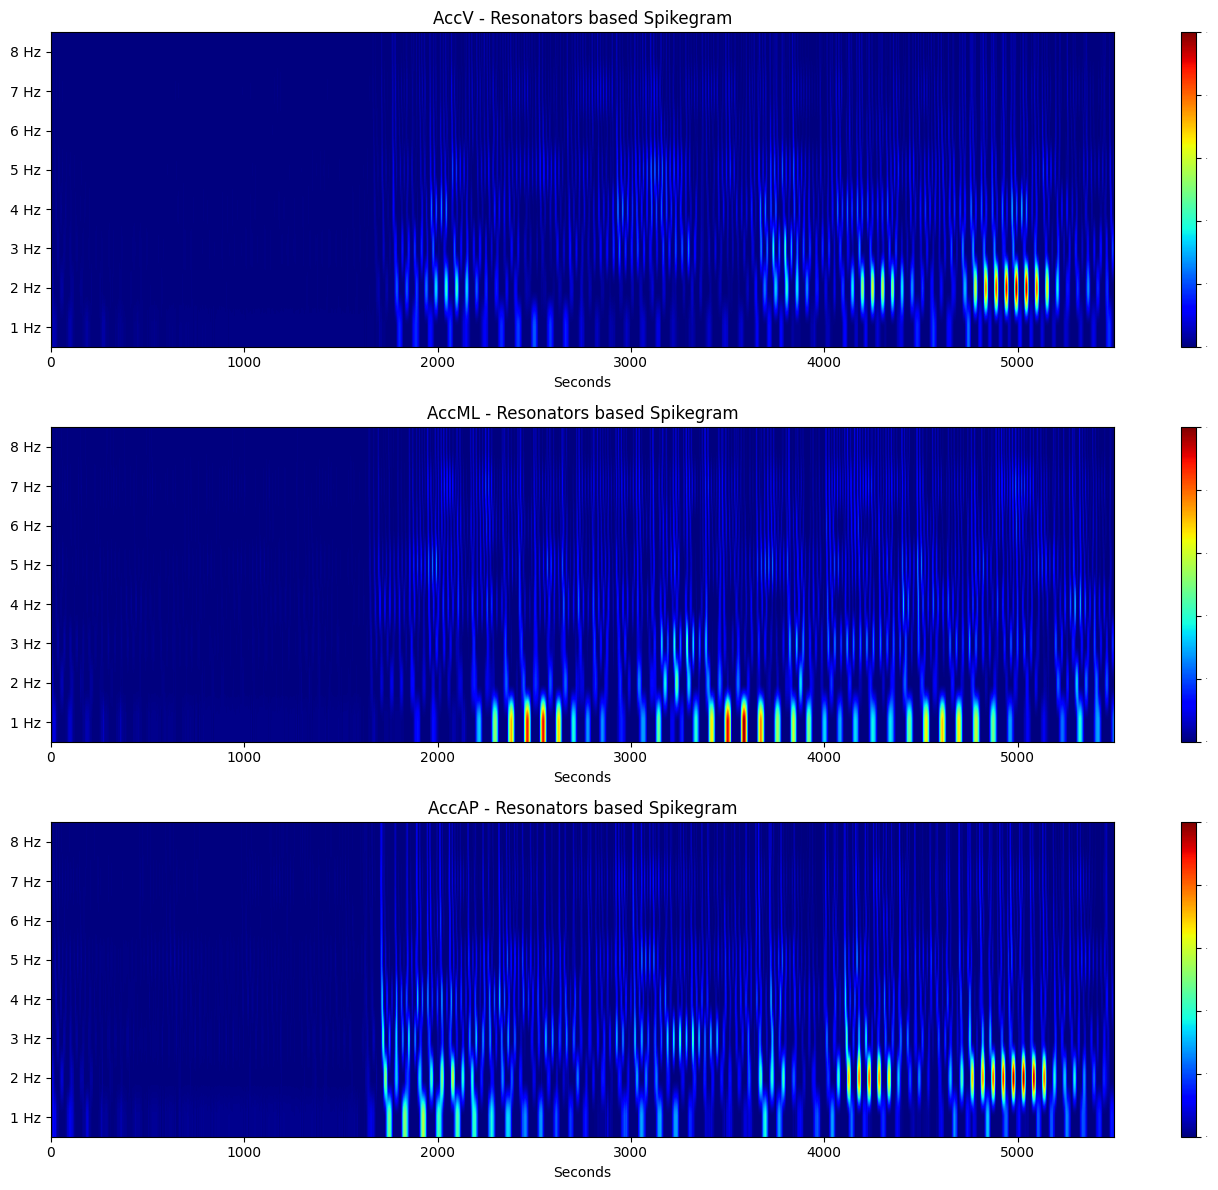

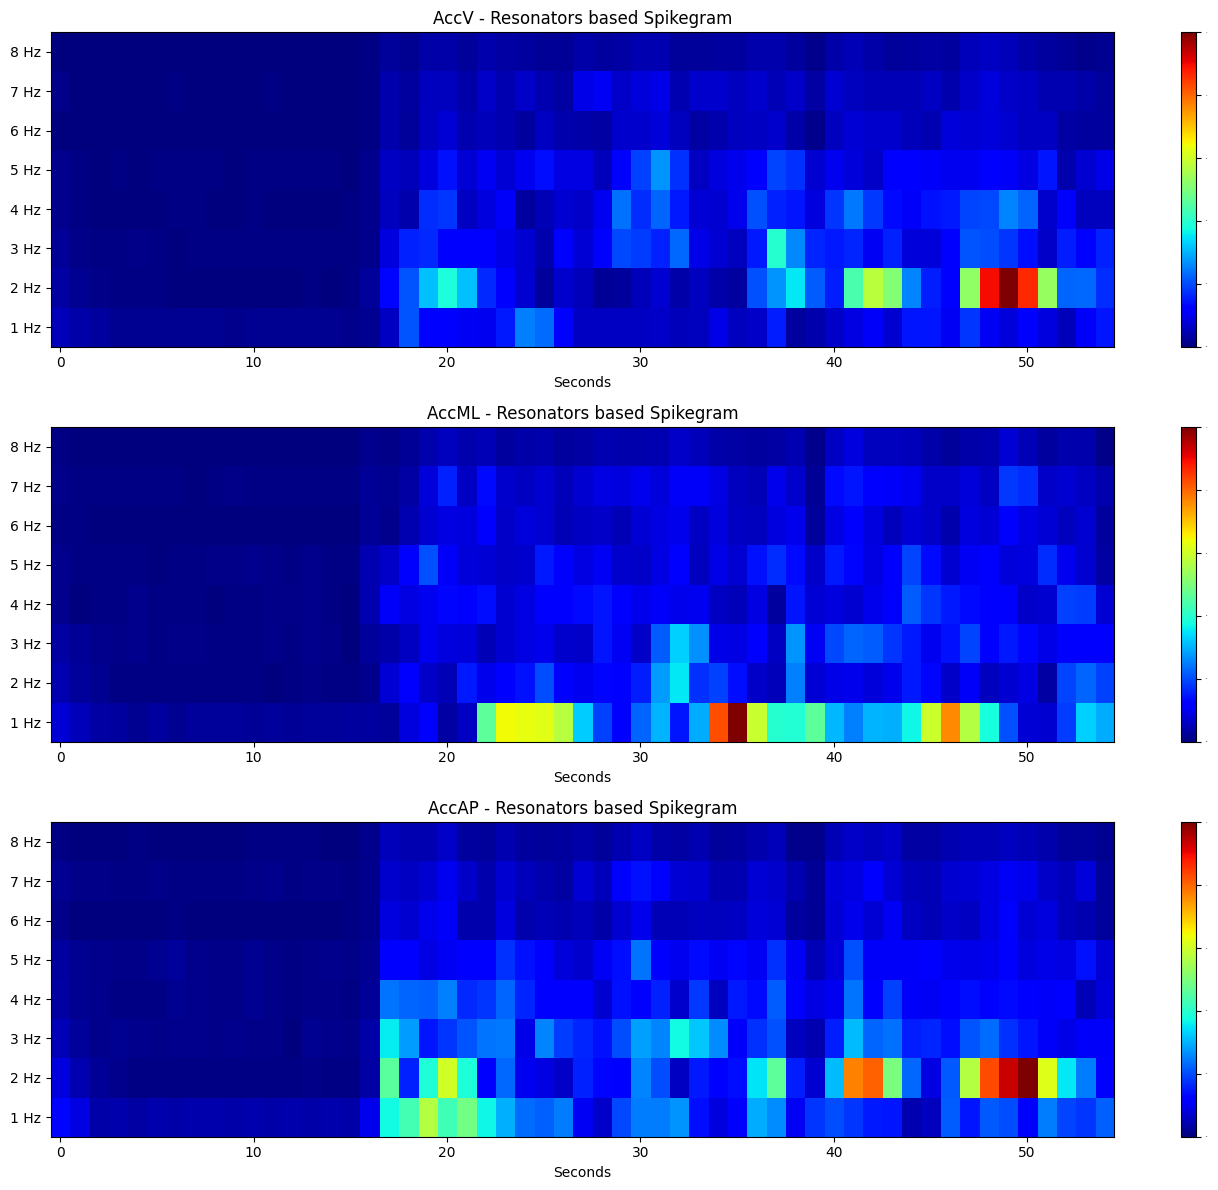

In [154]:
spikegram_bands = full_spikegram_to_bands(spikegram=spikegram, resonators_freqs=resonators_freqs, bands=bands)

spikes_bands_spikegram = {}
for axis, spikegram_axis in spikegram_bands.items():
    print(f'axis-{axis}')
    print(np.shape(spikegram_axis))
    window = 1000 // spikegram_time_window_ms
    spikes_bands_spikegram[axis] = spikegram_axis.reshape(spikegram_axis.shape[0], spikegram_axis.shape[1]//window, window).sum(axis=2)

for axis, spikegram_axis in spikes_bands_spikegram.items():
    print(f'axis-{axis}')
    print(np.shape(spikegram_axis))
    
# plot_full_spikegram(spikegram=spikegram_bands, resonators_spikes_dict=resonators_spikes_dict, bands=bands)
plot_full_spikegram(spikegram=spikegram_bands, resonators_spikes_dict=resonators_spikes_dict, bands=bands)

plot_full_spikegram(spikegram=spikes_bands_spikegram, resonators_spikes_dict=resonators_spikes_dict, bands=bands)

Now lets create the FFT based spectrogram and adapt it to our bands.

In [155]:
from scipy.signal import spectrogram

def spectrogram_from_signal(signal, sampling_rate):
    frequencies, times, sxx = spectrogram(signal, fs=sampling_rate, nperseg=sampling_rate, noverlap=0)
    fmin, fmax = 1, 8   # change to focus on different frequencies
    freq_mask = (frequencies >= fmin) & (frequencies <= fmax)
    sxx_filtered = sxx[freq_mask, :]
    frequencies_filtered = frequencies[freq_mask]
    return sxx_filtered, frequencies_filtered

def create_spectrogram(signal_dict_r, sampling_rate):
    spectrogram = {}
    for axis, signal in signal_dict_r.items():
        spectrogram[axis], frequencies = spectrogram_from_signal(signal=signal, sampling_rate=sampling_rate)
    return spectrogram, frequencies

In [156]:
spectrogram, spectrogram_frequencies = create_spectrogram(signal_dict_r=signal_dict_r, sampling_rate=clk_freq)

We now have the spectrogram in each axis.

In [157]:
def plot_spectrogram(spectrogram, title, fig=None, axs=None, y_label=None, is_bands=False):
    spectrogram_normalized = (spectrogram - np.min(spectrogram)) / (np.max(spectrogram) - np.min(spectrogram))

    # For testing single spikegram
    if fig==None:
        fig, axs = plt.subplots(1, 1, figsize=(14, 6))
    
    # Create the plot
    im = axs.imshow(spectrogram_normalized, aspect='auto', cmap='jet', origin='lower')
    if is_bands == False:
        axs.set_yticks(ticks=np.arange(spectrogram_normalized.shape[0]), labels=[f'{f:.2f} Hz' for f in y_label])
    else:
        axs.set_yticks(ticks=np.arange(spectrogram_normalized.shape[0]), labels=[f'{name}' for name in y_label.keys()])
    cbar = fig.colorbar(im, ax=axs)
    cbar.ax.tick_params(labelsize=0)
    axs.set_xlabel('Seconds')
    if is_bands == False:
        axs.set_ylabel('Frequencies')
    axs.set_title(f'{title} - FFT based Spectrogram')

def plot_full_spectrogram(spectrogram, signal_dict_r=None, bands=None, fig=None, axs=None, col=None):
    if col==None:
        fig, axs = plt.subplots(3, 1, figsize=(14, 12))
        if bands == None:
            for ax, axis in enumerate(signal_dict_r.keys()):
                plot_spectrogram(spectrogram=spectrogram[axis], title=axis, y_label=np.arange(1, 9, 1), is_bands=False, fig=fig, axs=axs[ax])
        if bands != None:
            for ax, axis in enumerate(signal_dict_r.keys()):
                plot_spectrogram(spectrogram=spectrogram[axis], title=axis, y_label=bands, is_bands=True, fig=fig, axs=axs[ax])
        fig.tight_layout()
        plt.show()
        
    else:
        if bands == None:
            for ax, axis in enumerate(resonators_spikes_dict.keys()):
                plot_spectrogram(spectrogram=spectrogram[axis], title=axis, y_label=np.arange(1, 9, 1), is_bands=False, fig=fig, axs=axs[ax][col])
        if bands != None:
            for ax, axis in enumerate(resonators_spikes_dict.keys()):
                plot_spectrogram(spectrogram=spectrogram[axis], title=axis, y_label=bands, is_bands=True, fig=fig, axs=axs[ax][col])

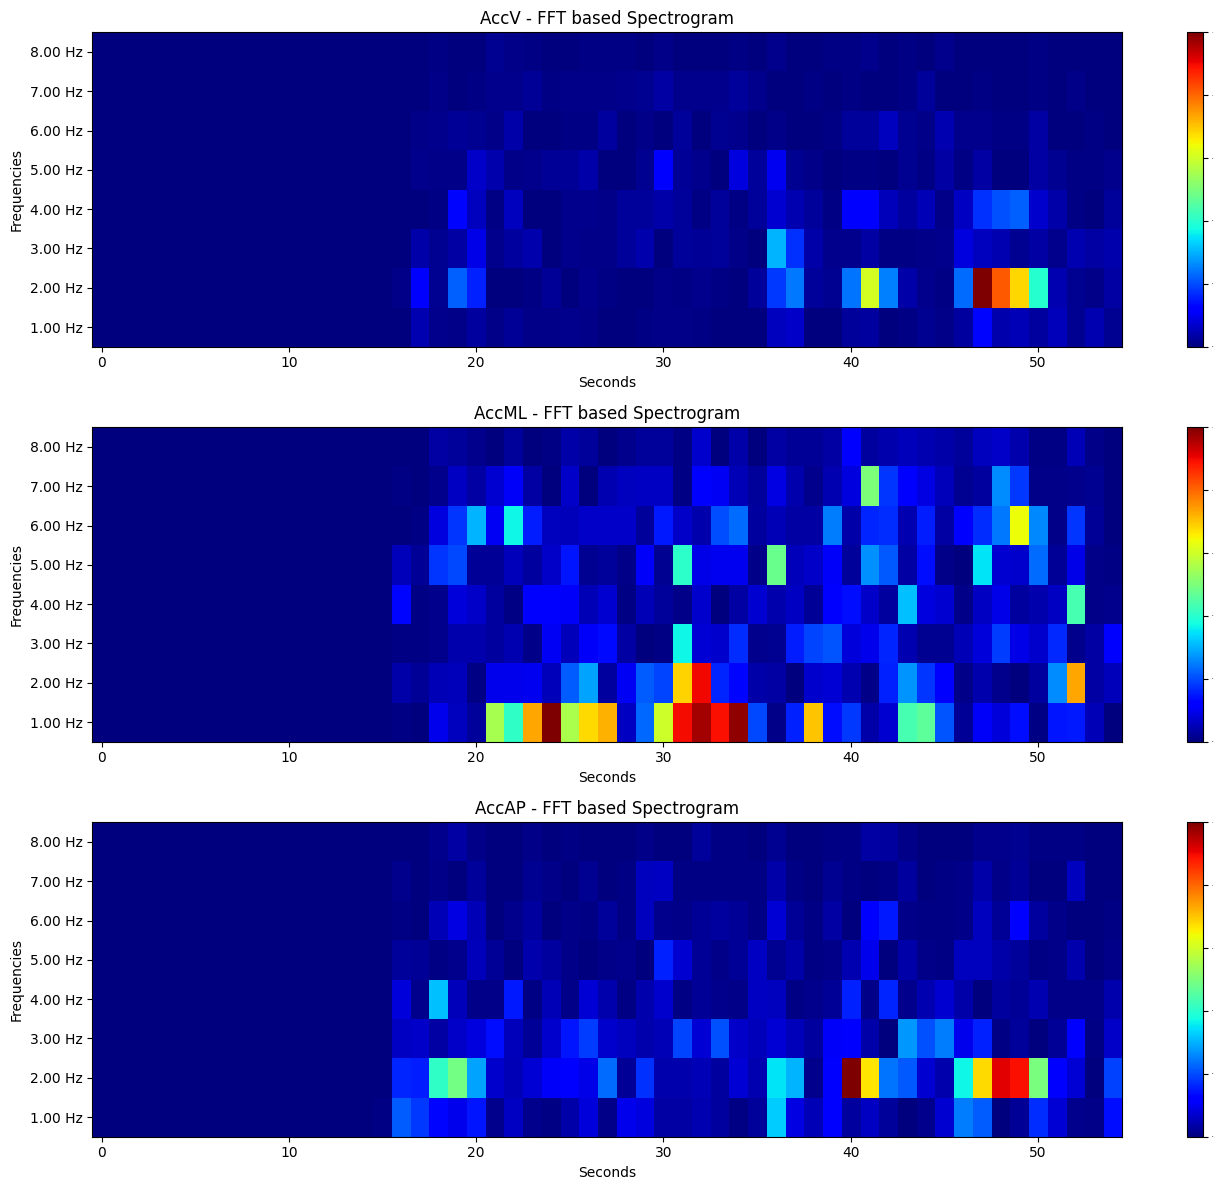

In [158]:
plot_full_spectrogram(spectrogram=spectrogram, signal_dict_r=signal_dict_r)

Now we will create the spectrogram in our bands.

In [159]:
def spectrogram_to_bands(spectrogram, freqs, bands):
    spectrogram_shape = spectrogram.shape
    freqs = np.array(freqs)
    spectrogram_bands = np.zeros((len(bands), spectrogram_shape[1]))
    spectrogram_bands[0] = np.sum(spectrogram[(freqs >= 0.5) & (freqs < 1.5)], axis=0)
    spectrogram_bands[1] = np.sum(spectrogram[(freqs >= 1.5) & (freqs < 2.5)], axis=0)
    spectrogram_bands[2] = np.sum(spectrogram[(freqs >= 2.5) & (freqs < 3.5)], axis=0)
    spectrogram_bands[3] = np.sum(spectrogram[(freqs >= 3.5) & (freqs < 4.5)], axis=0)
    spectrogram_bands[4] = np.sum(spectrogram[(freqs >= 4.5) & (freqs < 5.5)], axis=0)
    spectrogram_bands[5] = np.sum(spectrogram[(freqs >= 5.5) & (freqs < 6.5)], axis=0)
    spectrogram_bands[6] = np.sum(spectrogram[(freqs >= 6.5) & (freqs < 7.5)], axis=0)
    spectrogram_bands[7] = np.sum(spectrogram[(freqs >= 7.5) & (freqs < 8.5)], axis=0)
    return spectrogram_bands

def full_spectrogram_to_bands(spectrogram, spectrogram_freqs, bands):
    full_spectrogram_bands = {}
    for axis, axis_spectrogram in spectrogram.items():
        full_spectrogram_bands[axis] = spectrogram_to_bands(axis_spectrogram, spectrogram_freqs, bands)
    return full_spectrogram_bands

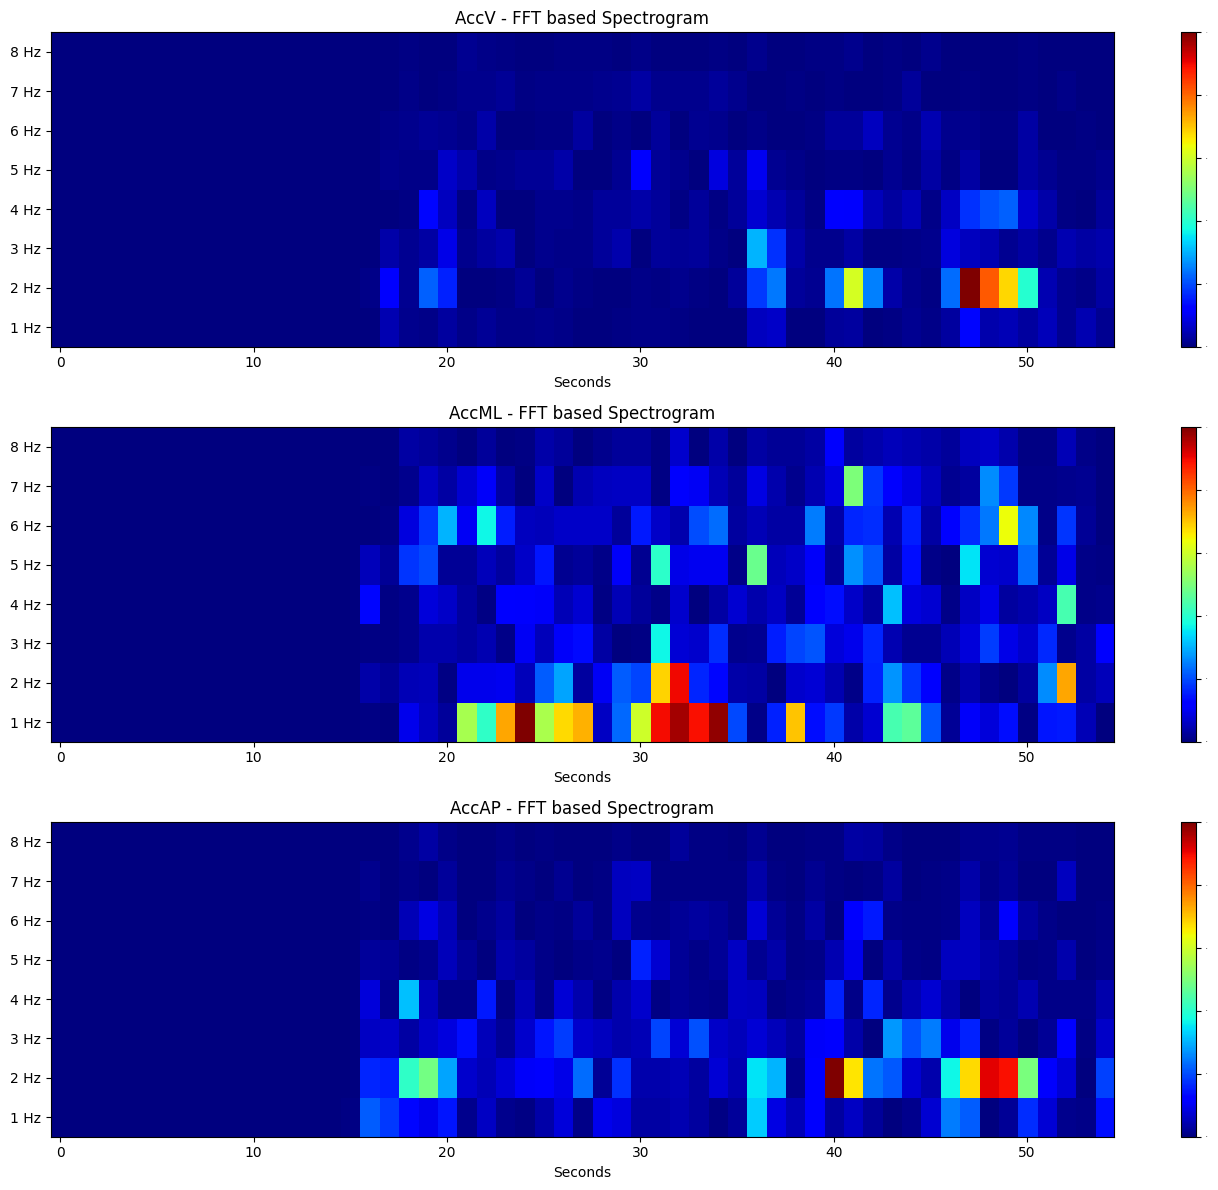

In [160]:
spectrogram_bands = full_spectrogram_to_bands(spectrogram=spectrogram, spectrogram_freqs=spectrogram_frequencies, bands=bands)

# plot_full_spikegram(spikegram=spikegram_bands, resonators_spikes_dict=resonators_spikes_dict, bands=bands)
plot_full_spectrogram(spectrogram=spectrogram_bands, signal_dict_r=signal_dict_r, bands=bands)

Now that we have both the Resonators based Spikegram and FFT based Spectrogram, lets plot them side by side to analyze their correlation.

In [161]:
def plot_full_spikegram_spectrogram(spectrogram, spikegram, signal_dict_r=None, resonators_spikes_dict=None, bands=None, save_fig=False):
    fig, axs = plt.subplots(3, 2, figsize=(14, 12))
    plot_full_spectrogram(spectrogram, signal_dict_r=signal_dict_r,
                        bands=bands, fig=fig, axs=axs, col=0)
    #plot_full_spikegram(spikegram, resonators_spikes_dict=resonators_spikes_dict,
                        #bands=bands, fig=fig, axs=axs, col=1)
    plot_full_spikegram(spikegram, resonators_spikes_dict=resonators_spikes_dict,
                        bands=bands, fig=fig, axs=axs, col=1)
    
    fig.tight_layout()
    if save_fig==True:
        if bands!=None:
            plt.savefig('Non-Bands correlation plot.png')
        else:
            plt.savefig('Bands correlation plot.png')
            
    plt.show()

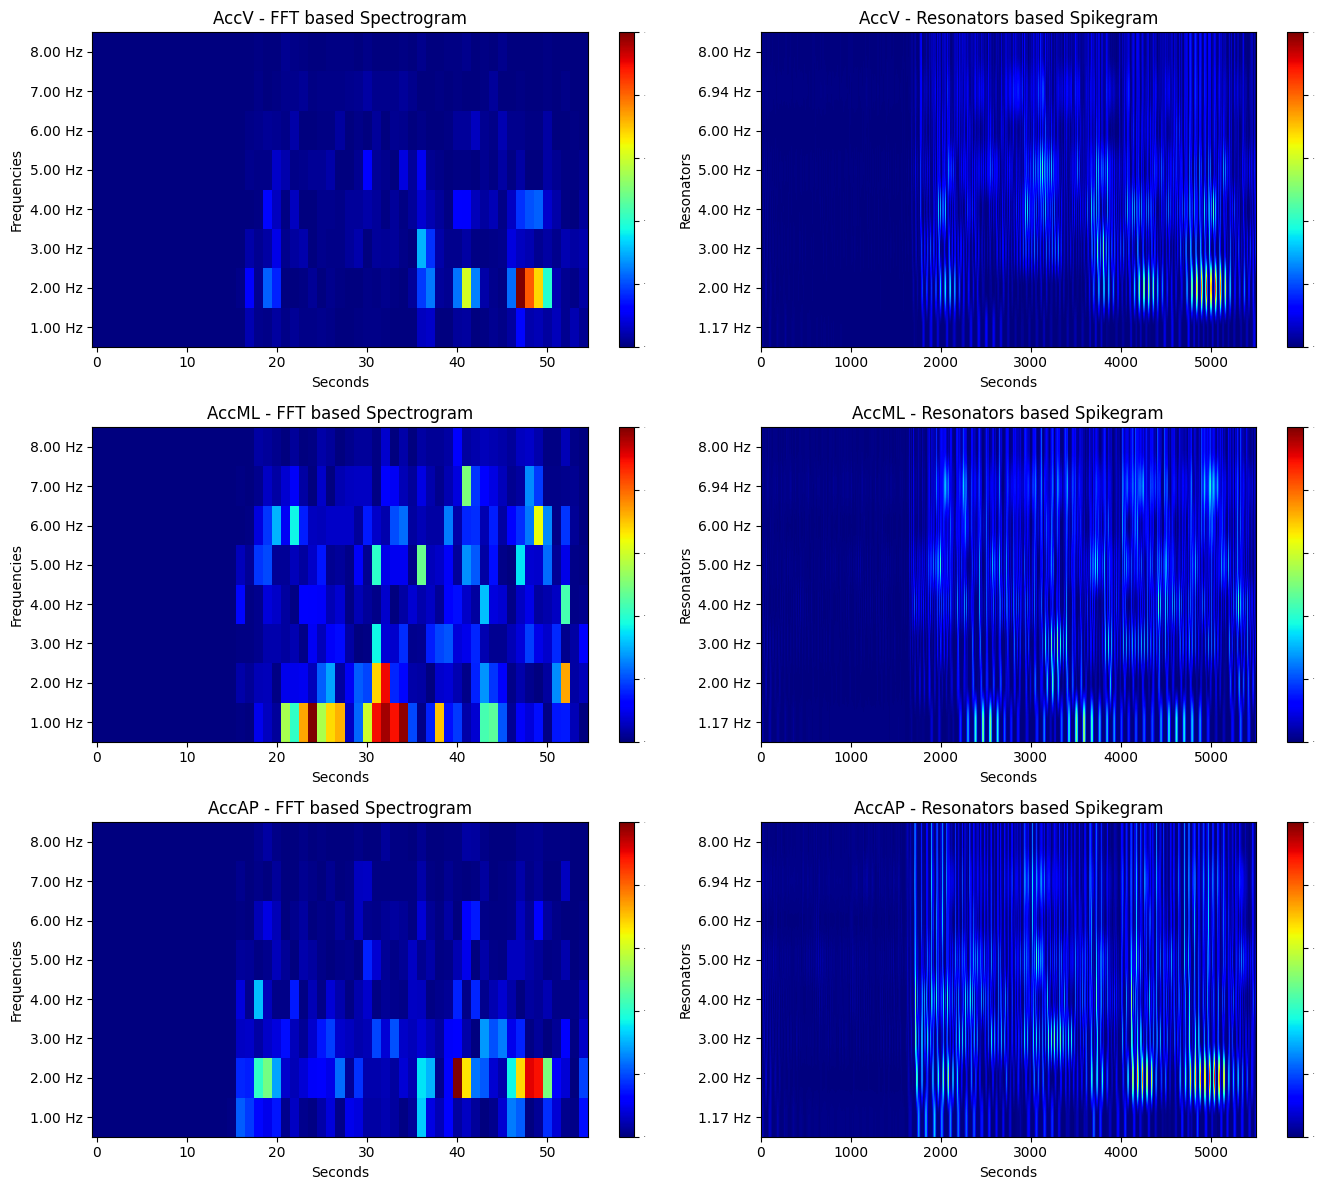

In [162]:
plot_full_spikegram_spectrogram(spectrogram=spectrogram, spikegram=spikegram,
                                signal_dict_r=signal_dict_r, resonators_spikes_dict=resonators_spikes_dict, save_fig=False)

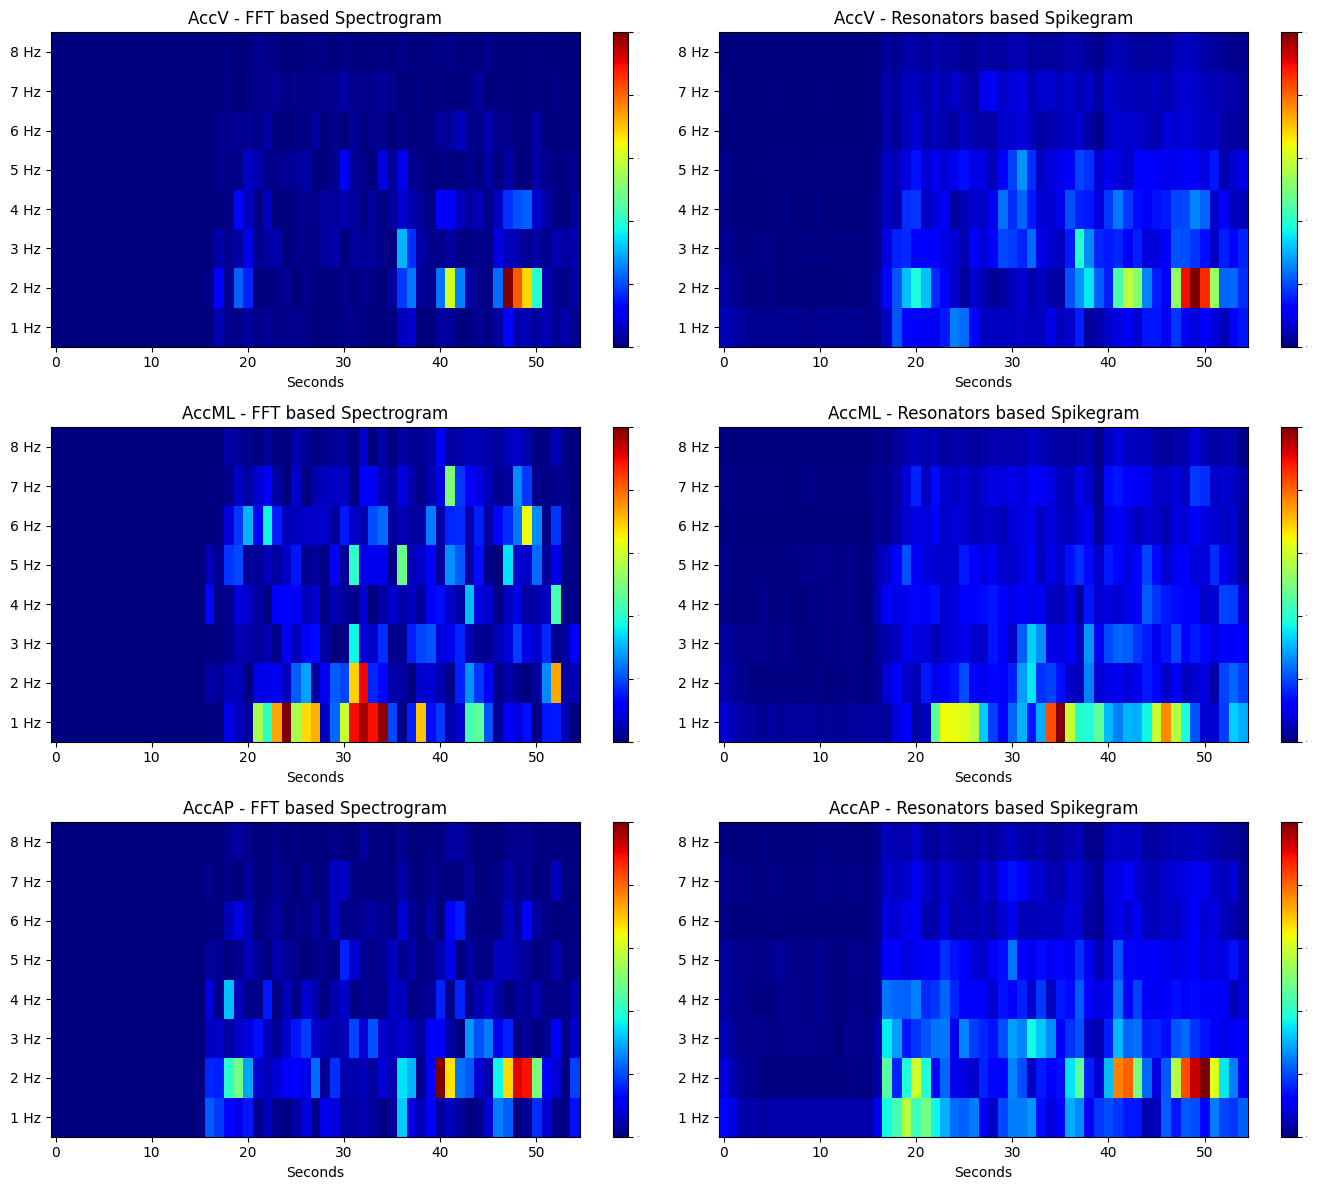

In [163]:
plot_full_spikegram_spectrogram(spectrogram=spectrogram_bands, spikegram=spikes_bands_spikegram,
                                signal_dict_r=signal_dict_r, resonators_spikes_dict=resonators_spikes_dict, bands=bands, save_fig=True)

## Saving and Loading Offline Data

### Saving Resonators Data  
In this section we will run over all files in tdcsfog (and maybe later defog) and save offline the resonators dict, fog and signal resampled dict and also the resonators spikes dict for much faster analysis.

In [164]:
import os
import glob
import pandas as pd
import pickle


def save_data(input_directory, output_directory, start_index, end_index, clock_frequency, fs, resonators_freqs):
    # Create output directory to save there the data offline
    os.makedirs(output_directory, exist_ok=True)
    
    # List all files in the directory
    files = sorted(glob.glob(os.path.join(input_directory, '*.csv')))  # Assuming CSV files
    lst_len = min(len(files),end_index)
    
    # Run on files
    for file_index in range(start_index, lst_len):
        file_path = files[file_index]
        file_name = os.path.basename(file_path).split('.')[0]  # Base name without extension
        
        # Create the data to save
        imu_signal = read_single_csv_file(input_directory, file_index)
        fog_dict = {label: np.array(imu_signal[label]) for label in ['StartHesitation', 'Turn', 'Walking']}
        signal_dict = {signal: np.array(imu_signal[signal]) for signal in ['AccV', 'AccML', 'AccAP']}
        time_s = len(signal_dict['AccV']) / fs
        resonators_dict, fog_dict_r, signal_dict_r = create_resonators(signal_dict=signal_dict,
                                                               fog_events_dict=fog_dict,
                                                               resonators_freqs=resonators_freqs,
                                                               f_source=fs,
                                                               f_new=clock_frequency,
                                                               lowcut=1,
                                                               highcut=8,
                                                               clk_freq=clock_frequency)

        resonators_spikes_dict = create_spikes_events(resonators_dict=resonators_dict,
                                              clk_freq=clock_frequency,
                                              time_s=time_s,
                                              plot_event=False)
        
        # Save each dictionary as a separate file
        save_dicts = {
            'resonators_dict': resonators_dict,
            'fog_dict_r': fog_dict_r,
            'signal_dict_r': signal_dict_r,
            'resonators_spikes_dict': resonators_spikes_dict,
            'fog_dict': fog_dict,
            'signal_dict': signal_dict,
            'time_s': time_s
        }
        
        file_save_path = os.path.join(output_directory, f"{file_index}_{file_name}.pkl")
        with open(file_save_path, 'wb') as f:
            pickle.dump(save_dicts, f)

        print(f"File Index:{file_index} \n File Name:{file_name} saved succesfully in path")
    print(f"Data saved in: {output_directory}")
    return None


In [165]:
# input_directory = f'D:\\University\\project_data_files\\tdcsfog\\files_with_fog_events'
# output_directory = f'D:\\University\\project_data_files\\tdscfog_offline_data'
start_index = 0
end_index = 412
clock_frequency = 15360
fs = 128
low_freq = [1.17,2]
medium_freq = [3,4,5]
high_freq = [6,6.94,8]
resonators_freqs = low_freq + medium_freq + high_freq

# If you want to save, remove comment
# save_data(input_directory, output_directory, start_index, end_index, clock_frequency, fs, resonators_freqs)

### Spikegram Offline Saving
In this section we will create the spikegram from our data for all our files and also resample the fog dict.  
We might save this data offline if we are satisfied and decided only to use the spikegram for our learning method and not the crude resonators spikes dict.

In [166]:
import numpy as np

def align_fog_to_spikegram_high_sampling(fog_dict, spikegram_dict, spikegram_time_window_ms, clock_frequency):
    # Access the first spikegram in spikegram_dict
    first_key = list(spikegram_dict.keys())[0]  # Get the first key
    first_spikegram = spikegram_dict[first_key]  # Access the first spikegram

    # Get the number of time bins (x-axis length)
    spikegram_length = first_spikegram.shape[1]
    
    spikegram_time_window_ms = 10  # Each bin in spikegram_dict is 10 ms
    
    # Sampling rate for fog_dict
    clock_frequency = 15360
    # Corresponding samples per spikegram bin (1536 samples per bin)
    fog_bin_size = int(spikegram_time_window_ms / (1000 / clock_frequency))
    
    
    # Create new fog_dict aligned with spikegram_dict
    aligned_fog_dict = {}
    for event_type, fog_samples in fog_dict.items():
        # Number of samples in fog_dict
        num_fog_samples = len(fog_samples)
        # Calculate the number of bins for fog_dict based on spikegram size
        aligned_fog = []
        
        for i in range(0, num_fog_samples, fog_bin_size):
            # Extract samples for this bin
            bin_samples = fog_samples[i:i+fog_bin_size]
            # Check if any sample in this bin is 1 (event occurred)
            aligned_fog.append(1 if np.any(bin_samples) else 0)
        
        # Truncate or pad to match the spikegram size
        aligned_fog = aligned_fog[:spikegram_length]  # Truncate to match spikegram size
        if len(aligned_fog) < spikegram_length:
            aligned_fog.extend([0] * (spikegram_length - len(aligned_fog)))  # Pad with 0s if shorter
        
        
        aligned_fog_dict[event_type] = np.array(aligned_fog)
    
    return aligned_fog_dict

import os
import pickle
from tqdm import tqdm

def save_spikegrams(offline_directory, output_directory, spikegram_time_window_ms, clock_frequency):
    # Create output directory to save there the spikegram offline
    os.makedirs(output_directory, exist_ok=True)
    
    # Iterate through all files in the directory
    with tqdm(total=len(os.listdir(offline_directory))) as pbar:
        for file in sorted(os.listdir(offline_directory)):
            if file.endswith('.pkl'):  # Ensure it's a grouped pickle file
                file_path = os.path.join(offline_directory, file)
                file_name = os.path.basename(file).split('.')[0]  # Extract base name
                
                # Load the data
                with open(file_path, 'rb') as f:
                    dictionaries = pickle.load(f)
                
                # Load relevant data
                resonators_spikes_dict = dictionaries['resonators_spikes_dict']
                time_s = dictionaries['time_s']
                fog_dict_r = dictionaries['fog_dict_r']
                
                # Create spikegram
                spikegram = create_spikegram(resonators_spikes_dict=resonators_spikes_dict,
                                            clk_freq=clock_frequency,
                                            window_ms=spikegram_time_window_ms,
                                            time_s=time_s)
                
                # Align FoG dict
                spikegram_fog_dict = align_fog_to_spikegram_high_sampling(fog_dict=fog_dict_r,
                                                                        spikegram_dict=spikegram,
                                                                        spikegram_time_window_ms=spikegram_time_window_ms,
                                                                        clock_frequency=clock_frequency)
                
                # Save each dictionary as a separate file
                save_dict = {
                    'spikegram_dict': spikegram,
                    'spikegram_fog_dict': spikegram_fog_dict
                }
                
                file_save_path = os.path.join(output_directory, f"{file_name}_spikegram.pkl")
                with open(file_save_path, 'wb') as f:
                    pickle.dump(save_dict, f)
                    
            pbar.update(1)   
            
    return

In [167]:
offline_directory = f'D:\\University\\tdscfog_offline_data'
output_directory = 'D:\\University\\tdscfog_spikegram_offline_data'
spikegram_time_window_ms = 10
clock_frequency = 15360

# save_spikegrams(offline_directory, output_directory, spikegram_time_window_ms, clock_frequency)

### Spikegram Offline Loading  
In this section we will load all the spikegrams in preperation for the learning algorithm

In [168]:
import os
import pickle

def load_all_saved_data(offline_directory):
    # Define the offline data directory
    
    if not os.path.exists(offline_directory):
        raise FileNotFoundError(f"The directory {offline_directory} does not exist.")
    
    # Initialize a dictionary to store all loaded data
    all_data = {}
    
    # Iterate through all grouped .pkl files in the directory
    for file in sorted(os.listdir(offline_directory)):
        if file.endswith('.pkl'):  # Ensure it's a grouped pickle file
            file_path = os.path.join(offline_directory, file)
            file_name = os.path.basename(file).split('.')[0]  # Extract base name
            
            # Load the grouped data
            with open(file_path, 'rb') as f:
                grouped_data = pickle.load(f)
            
            # Add to the dictionary under the file name
            all_data[file_name] = grouped_data
    
    return all_data


In [169]:
offline_directory = f'D:\\University\\tdscfog_spikegram_offline_data'
# all_data = load_all_saved_data(offline_directory)